<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import datetime as dt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

# I. EDA

In [2]:
# Load the data and get a look at the first 5 rows
df_house = pd.read_csv('housing.csv')
df_house.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [3]:
# Get the overall dimensions of the dataframe
df_house.shape

(1460, 81)

In [4]:
# Get info on all the columns of the dataframe
df_house.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
# Get some stats on the dataframe
df_house.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

           ...         WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count      ...        1460.000000  1460.000000    1460.000000  1460.000000   
mean       ...          94.244521    46.660274      21.954110     3.409589   
std        ...         125.338794    66.256028      61.119149    29.317331   
min        ...           0.000000     0.000000       0.000000     0.000000   
25%        ...           0.000000     0.000000       0.000000     0.000000   
50%        ...           0.000000    25.000000       0.000000     0.000000   
75%        ...         168.000000    68.000000       0.000000     0.000000   
max        ...         857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean     15.060959     2.758904     43.489041     6.321918  2007.815753   
std      55.757415    40.177307    496.123024     2.703626     1.328095   
min       0.000000     0.000000      0.000000     1.000000  2006.000000   
25%       0.000000     0.000000      0.000000     5.000000  2007.000000   
50%       0.000000     0.000000      0.000000     6.000000  2008.000000   
75%       0.000000     0.000000      0.000000     8.000000  2009.000000   
max     480.000000   738.000000  15500.000000    12.000000  2010.000000   

           SalePrice  
count    1460.000000  
mean   180921.195890  
std     79442.502883  
min     34900.000000  
25%    129975.000000  
50%    163000.000000  
75%    214000.000000  
max    755000.000000  

[8 rows x 38 columns]

In [6]:
# Check columns datatype and see the non-numerical columns
# Start with the non-numerical columns for data cleanup
df_house.columns[df_house.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [7]:
# Check each of the columns and get an idea for the sample values for each
df_house[df_house.columns[df_house.isnull().any()].tolist()].sample(10)

LotFrontage Alley MasVnrType  MasVnrArea BsmtQual BsmtCond BsmtExposure  \
13           91.0   NaN      Stone       306.0       Gd       TA           Av   
1300          NaN   NaN       None       344.0       Gd       TA           No   
197         174.0   NaN       None         0.0       TA       TA           No   
523         130.0   NaN      Stone       762.0       Ex       TA           Gd   
25          110.0   NaN      Stone       640.0       Gd       TA           No   
970          60.0   NaN       None         0.0       TA       TA           No   
1377         60.0  Grvl       None         0.0       TA       TA           No   
168          62.0   NaN       None         0.0       Gd       TA           No   
1387         60.0  Grvl       None         0.0       TA       TA           No   
551          50.0   NaN       None         0.0       TA       TA           No   

     BsmtFinType1 BsmtFinType2 Electrical FireplaceQu GarageType  GarageYrBlt  \
13            Unf          Unf      SBrkr          Gd     Attchd       2006.0   
1300          GLQ          Unf      SBrkr          TA     Attchd       1999.0   
197           GLQ          LwQ      SBrkr          Ex     Detchd       1918.0   
523           GLQ          Unf      SBrkr          Gd    BuiltIn       2007.0   
25            Unf          Unf      SBrkr          Gd     Attchd       2007.0   
970           Unf          Unf      FuseA         NaN        NaN          NaN   
1377          LwQ          BLQ      SBrkr         NaN     Detchd       1977.0   
168           Unf          Unf      SBrkr          Gd     Attchd       2004.0   
1387          Rec          LwQ      SBrkr          Gd     Detchd       1916.0   
551           Rec          Unf      FuseA         NaN     Attchd       1957.0   

     GarageFinish GarageQual GarageCond PoolQC  Fence MiscFeature  
13            RFn         TA         TA    NaN    NaN         NaN  
1300          Fin         TA         TA    NaN    NaN         NaN  
197           Unf         TA         TA     Ex  GdPrv         NaN  
523           Fin         TA         TA    NaN    NaN         NaN  
25            RFn         TA         TA    NaN    NaN         NaN  
970           NaN        NaN        NaN    NaN    NaN         NaN  
1377          Unf         TA         TA    NaN    NaN         NaN  
168           Fin         TA         TA    NaN    NaN         NaN  
1387          Unf         TA         TA    NaN   GdWo         NaN  
551           Fin         TA         TA    NaN    NaN         NaN

In [8]:
# Create a list of default values for all columns with NaN
# For LotFrontage, use the median value of the dataset
IMPUTE_COLUMNS = df_house.columns[df_house.isnull().any()].tolist()
IMPUTE_VALUES = [df_house['LotFrontage'].median(),'NA','None',0,'NA','NA','NA','NA','NA','SBrkr','NA','NA',0,'NA','NA','NA','NA','NA','NA']

In [9]:
# Impute the default values on columns with NaN values
for key, value in dict(zip(IMPUTE_COLUMNS,IMPUTE_VALUES)).items():
    df_house[key].fillna(value, inplace=True)

In [10]:
# Re-check again
df_house.columns[df_house.isnull().any()]

Index([], dtype='object')

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


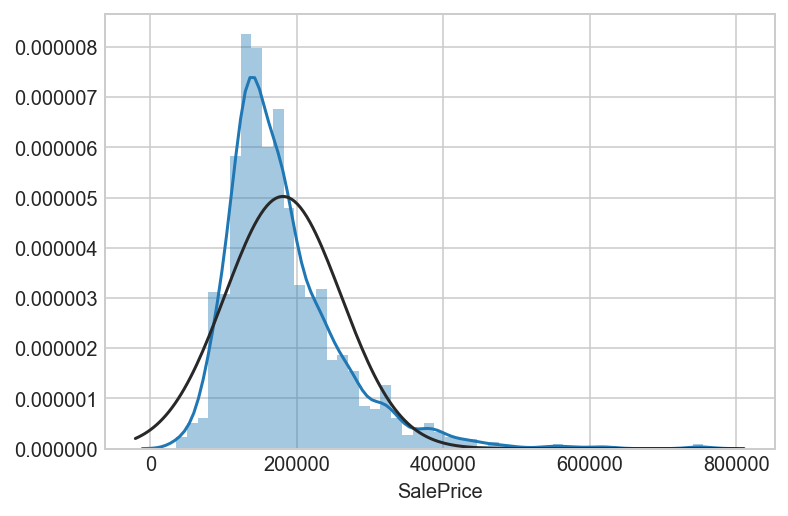

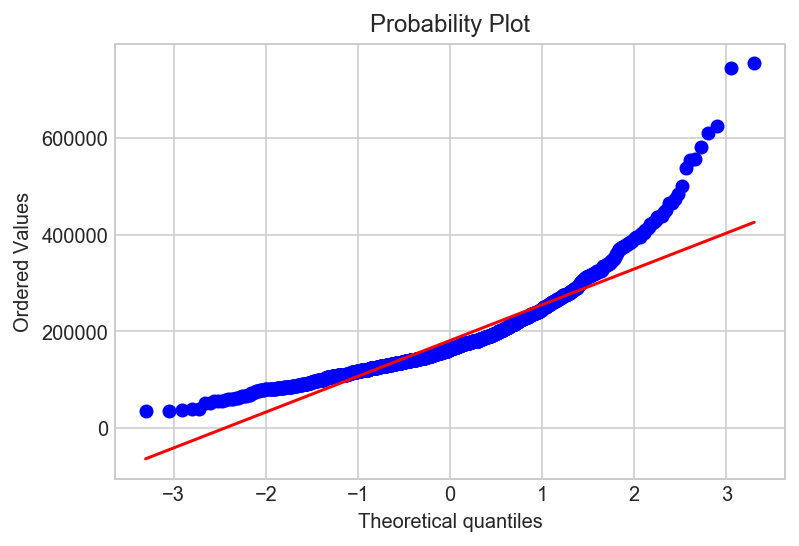

In [11]:
# Do some visualizations, (INITIAL VIEW and ASSUMPTIONS)

# Check the distribution of the Target Variable: SalePrice
from scipy.stats import norm
sns.distplot(df_house['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(df_house['SalePrice'], plot=plt)

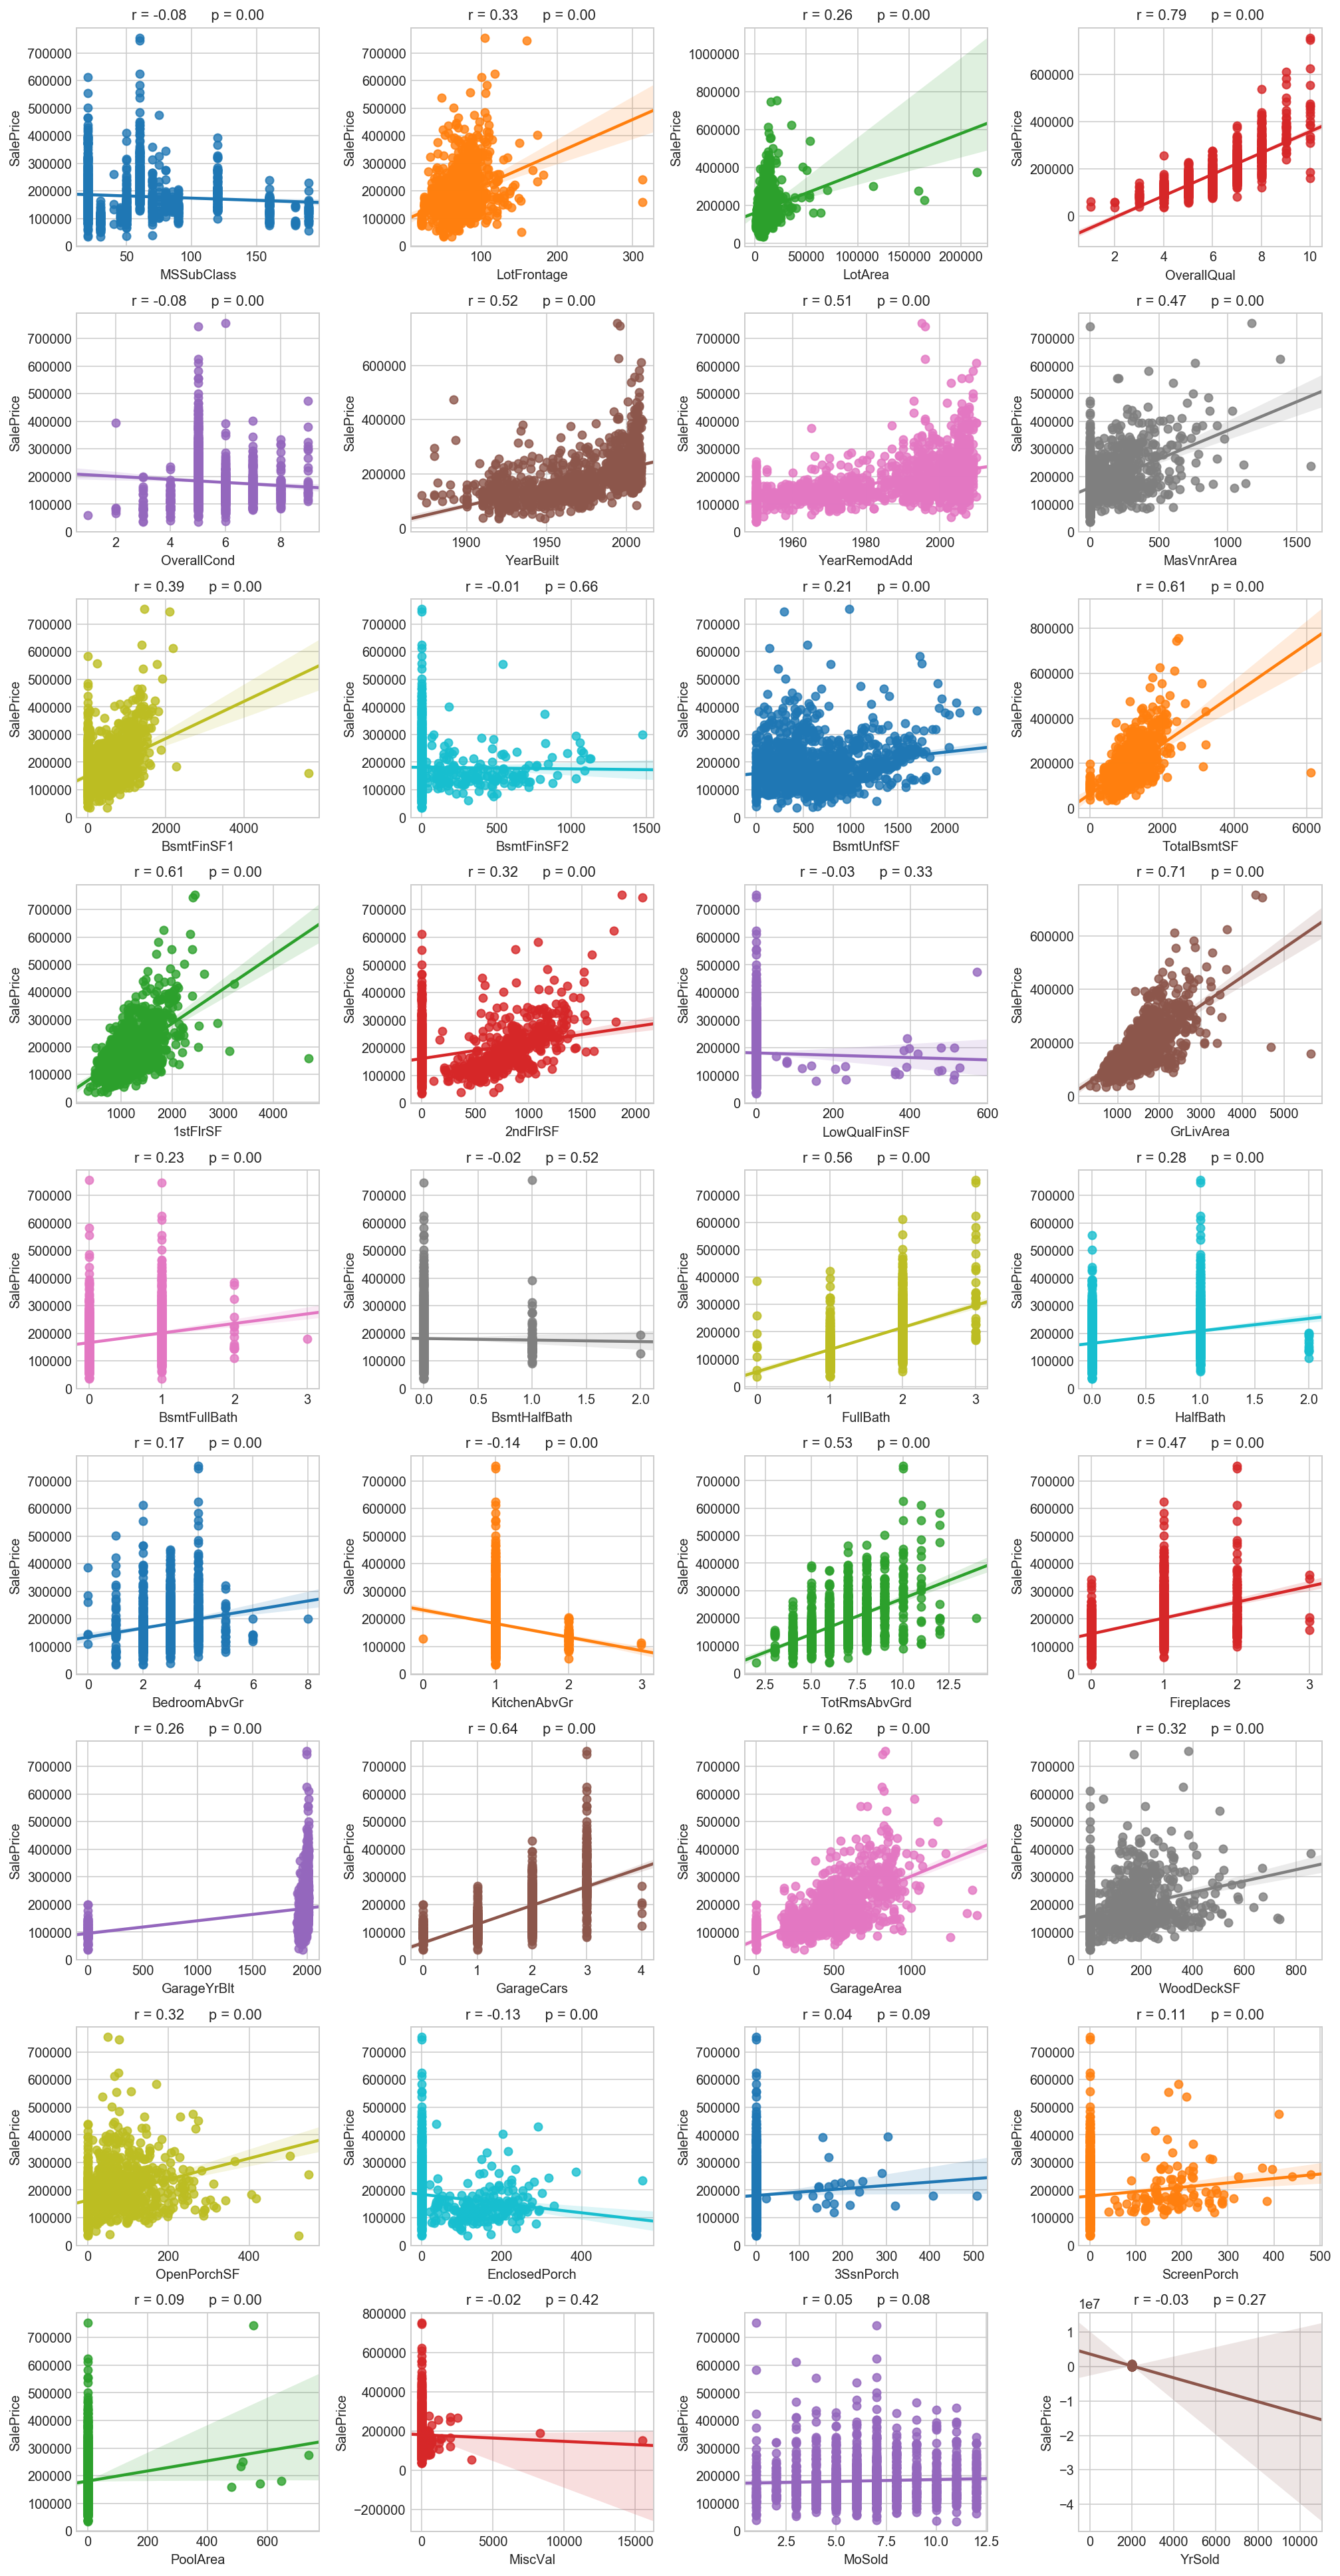

In [12]:
# Plot the correlations and p of numerical values vs SalePrice
numerical_feats = df_house.dtypes[df_house.dtypes != "object"].index

nr_rows = 9
nr_cols = 4

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_house[li_plot_num_feats[i]], df_house['SalePrice'], ax = axs[r][c])
            stp = stats.pearsonr(df_house[li_plot_num_feats[i]], df_house['SalePrice'])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


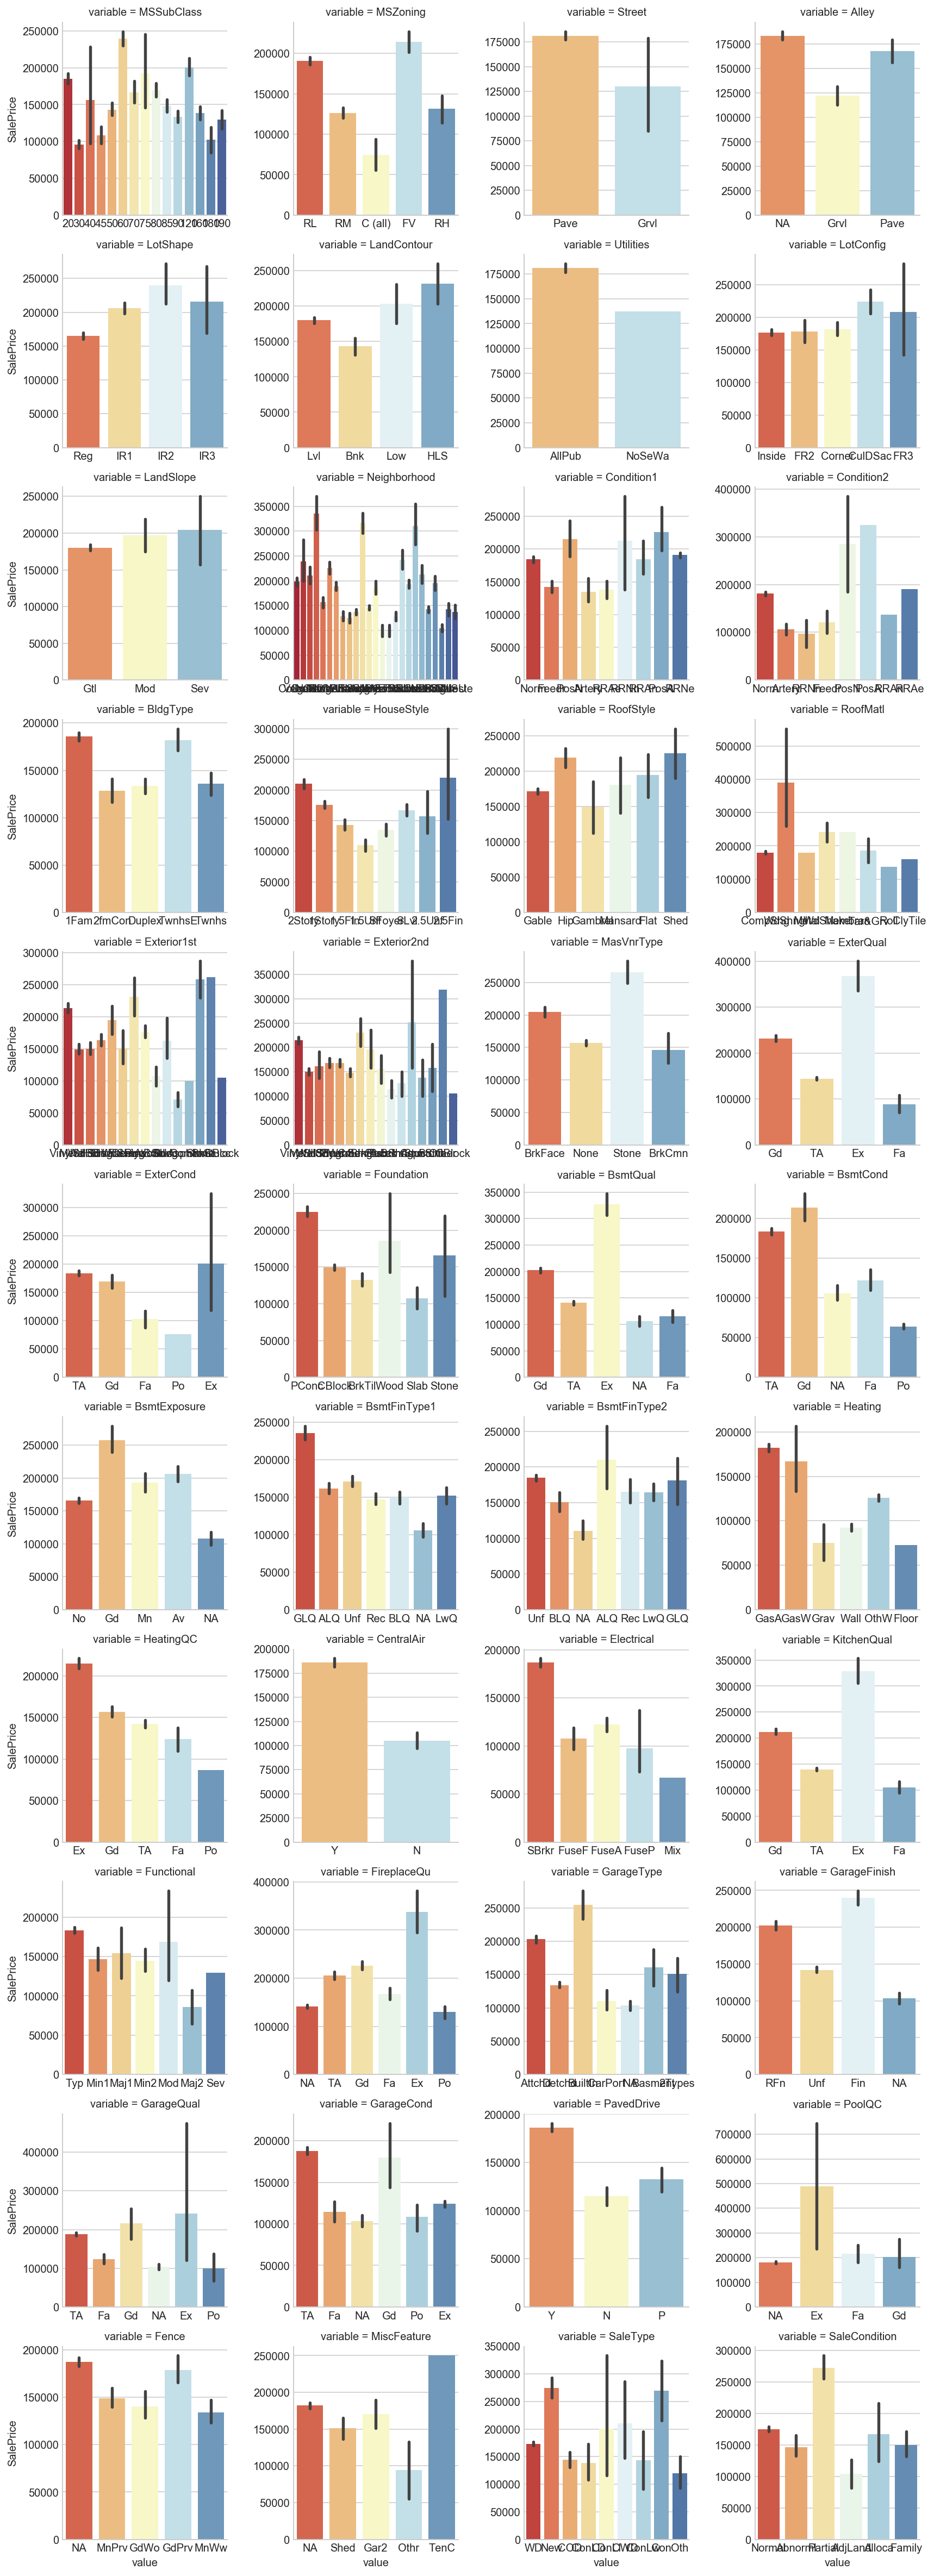

In [13]:
# Plot Categorical Values vs SalePrice
quant_features = df_house.select_dtypes(exclude='object').drop('MSSubClass',axis=1)
cat_features = df_house[df_house.columns[~df_house.columns.isin(quant_features.columns)]]

cat_plot = pd.melt(cat_features.join(df_house['SalePrice']),id_vars='SalePrice')
g = sns.FacetGrid(cat_plot, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.barplot, 'value','SalePrice', palette='RdYlBu')

# II. FEATURE ENGINEERING FOR M1 & M2 AND MODELS

In [14]:
# Filter out all the non-residential records
# MSZoning: Identifies the general zoning classification of the sale.
#        A	Agriculture
#        C	Commercial
#        FV	Floating Village Residential
#        I	Industrial
#        RH	Residential High Density
#        RL	Residential Low Density
#        RP	Residential Low Density Park 
#        RM	Residential Medium Density
df_house_res = df_house[df_house['MSZoning'].isin(['FV', 'RH', 'RL', 'RP', 'RM'])]

In [15]:
# Group the related features together before visualization
F_FIXED = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities',
           'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt',
           'YearRemodAdd', 'Foundation','TotalBsmtSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
           'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea']
F_NFXED = ['OverallQual', 'OverallCond', 'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea',
           'ExterQual','ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
           'HeatingQC','CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
           'GarageQual','GarageCond','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
           'PoolArea','PoolQC','Fence','MiscFeature','MiscVal']
F_SALES = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']

In [16]:
# Sale Conditions are excluded for both DataFrames of Model 1 and 2
# Create DataFrame for Model 1 (Fixed + Target Variable)
df_house_m1 = df_house_res[F_FIXED + ['SalePrice', 'YrSold']]
df_house_m1.sample(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
834           20       RL         75.0     7875   Pave    NA      Reg   
236           20       RL         65.0     8773   Pave    NA      Reg   
1045          20       RL         69.0    13680   Pave    NA      IR1   
703          190       RM         76.0     7630   Pave    NA      Reg   
492           60       RL        105.0    15578   Pave    NA      IR1   

     LandContour Utilities LotConfig   ...   FullBath HalfBath KitchenAbvGr  \
834          Lvl    AllPub    Inside   ...          1        0            1   
236          Lvl    AllPub       FR2   ...          2        0            1   
1045         Lvl    AllPub   CulDSac   ...          2        0            1   
703          Lvl    AllPub    Inside   ...          2        0            2   
492          Lvl    AllPub    Corner   ...          2        1            1   

     TotRmsAbvGrd Fireplaces GarageYrBlt  GarageCars  GarageArea SalePrice  \
834             6          0      1961.0           2         456    139950   
236             6          0      2004.0           2         494    185500   
1045            8          1      1955.0           2         452    139600   
703             8          1      1999.0           2         672    140000   
492             8          0      2006.0           2         429    172785   

      YrSold  
834     2008  
236     2010  
1045    2009  
703     2010  
492     2006  

[5 rows x 33 columns]

In [17]:
# Create DataFrame for Model 2 (Fixed + Non-Fixed + Target Variable)
df_house_m2 = df_house_res[F_FIXED + F_NFXED+ ['SalePrice', 'SaleCondition', 'YrSold']]
df_house_m2.sample(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
966           50       RL        130.0     9600   Pave    NA      IR1   
104           50       RM         69.0     7758   Pave    NA      Reg   
1126         120       RL         53.0     3684   Pave    NA      Reg   
1270          40       RL         69.0    23595   Pave    NA      Reg   
1214          85       RL         69.0    10205   Pave    NA      IR1   

     LandContour Utilities LotConfig   ...   3SsnPorch ScreenPorch PoolArea  \
966          HLS    AllPub    Inside   ...           0           0        0   
104          Lvl    AllPub    Corner   ...           0         184        0   
1126         Lvl    AllPub    Inside   ...           0           0        0   
1270         Low    AllPub    Inside   ...           0           0        0   
1214         Lvl    AllPub    Inside   ...           0           0        0   

     PoolQC Fence MiscFeature  MiscVal  SalePrice SaleCondition  YrSold  
966      NA    NA          NA        0     160000        Normal    2009  
104      NA    NA          NA        0     169500        Normal    2007  
1126     NA    NA          NA        0     174000        Normal    2009  
1270     NA    NA          NA        0     260000        Normal    2010  
1214     NA    NA          NA        0     134500        Normal    2006  

[5 rows x 71 columns]

In [18]:
# Feature Engineering - Calculate Age of the Building
# df_house_m1['Age'] = df_house_m1['YrSold'] - df_house_m1['YearBuilt']
# df_house_m2['Age'] = df_house_m1['YrSold'] - df_house_m2['YearBuilt']
df_house_m1.insert(len(df_house_m1.columns), 'Age', df_house_m1['YrSold'] - df_house_m1['YearBuilt'])
df_house_m2.insert(len(df_house_m2.columns), 'Age', df_house_m2['YrSold'] - df_house_m2['YearBuilt'])

In [19]:
# Feature Engineering - Remodeled Flag (Y/N)
# df_house_m1['Remodel'] = np.where(df_house_m1['YearBuilt'] == df_house_m1['YearRemodAdd'], 0, 1)
# df_house_m2['Remodel'] = np.where(df_house_m2['YearBuilt'] == df_house_m2['YearRemodAdd'], 0, 1)
df_house_m1.insert(len(df_house_m1.columns), 'Remodel', np.where(df_house_m1['YearBuilt'] == df_house_m1['YearRemodAdd'], 0, 1))
df_house_m2.insert(len(df_house_m2.columns), 'Remodel', np.where(df_house_m2['YearBuilt'] == df_house_m2['YearRemodAdd'], 0, 1))

In [20]:
# Feature Engineering - Calculate Age of the Garage
# df_house_m1['AgeGarage'] = np.where(df_house_m1['GarageYrBlt'] == 0, 0, dt.date.today().year - df_house_m1['GarageYrBlt'])
# df_house_m2['AgeGarage'] = np.where(df_house_m2['GarageYrBlt'] == 0, 0, dt.date.today().year - df_house_m2['GarageYrBlt'])
df_house_m1.insert(len(df_house_m1.columns), 'AgeGarage', np.where(df_house_m1['GarageYrBlt'] == 0, 0, dt.date.today().year - df_house_m1['GarageYrBlt']))
df_house_m2.insert(len(df_house_m2.columns), 'AgeGarage', np.where(df_house_m2['GarageYrBlt'] == 0, 0, dt.date.today().year - df_house_m2['GarageYrBlt']))

In [21]:
# Drop the Old Columns
df_house_m1 = df_house_m1.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])
df_house_m2 = df_house_m2.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])

In [22]:
# Get Dummy Variables except Condition 2
# Get the Dummy Variables for all except Condition 1 and 2 since these 2 columns have overlapping values 
df_house_m1 = pd.get_dummies(data=df_house_m1, columns=['MSSubClass','MSZoning','Street', 'Alley','LotShape',
                                                        'LandContour','Utilities','LotConfig','LandSlope',
                                                        'Neighborhood','Condition1','BldgType','HouseStyle',
                                                        'Foundation'], drop_first=True)

df_house_m2 = pd.get_dummies(data=df_house_m2, columns=['MSSubClass','MSZoning','Street', 'Alley','LotShape',
                                                        'LandContour','Utilities','LotConfig','LandSlope',
                                                        'Neighborhood','Condition1','BldgType','HouseStyle',
                                                        'RoofStyle','RoofMatl', 'Exterior1st', 'MasVnrType', 
                                                        'Foundation','Heating','Electrical','GarageType', 'MiscFeature'],
                             drop_first=True)

In [23]:
#Iterate through Condition2 and map to the dummy variables of Condition1 except Artery which has been dropped
for index, row in df_house_m1.iterrows():
    if row['Condition2'] == 'Feedr':
        df_house_m1.at[index, 'Condition1_Feedr'] = 1
    elif row['Condition2'] == 'Norm':
        df_house_m1.at[index, 'Condition1_Norm'] = 1
    elif row['Condition2'] == 'PosA':
        df_house_m1.at[index, 'Condition1_PosA'] = 1
    elif row['Condition2'] == 'PosN':
        df_house_m1.at[index, 'Condition1_PosN'] = 1
    elif row['Condition2'] == 'RRAe':
        df_house_m1.at[index, 'Condition1_RRAe'] = 1
    elif row['Condition2'] == 'RRAn':
        df_house_m1.at[index, 'Condition1_RRAn'] = 1
    elif row['Condition2'] == 'RRNe':
        df_house_m1.at[index, 'Condition1_RRNe'] = 1
    elif row['Condition2'] == 'RRNn':
        df_house_m1.at[index, 'Condition1_RRNn'] = 1
        
for index, row in df_house_m2.iterrows():
    if row['Condition2'] == 'Feedr':
        df_house_m2.at[index, 'Condition1_Feedr'] = 1
    elif row['Condition2'] == 'Norm':
        df_house_m2.at[index, 'Condition1_Norm'] = 1
    elif row['Condition2'] == 'PosA':
        df_house_m2.at[index, 'Condition1_PosA'] = 1
    elif row['Condition2'] == 'PosN':
        df_house_m2.at[index, 'Condition1_PosN'] = 1
    elif row['Condition2'] == 'RRAe':
        df_house_m2.at[index, 'Condition1_RRAe'] = 1
    elif row['Condition2'] == 'RRAn':
        df_house_m2.at[index, 'Condition1_RRAn'] = 1
    elif row['Condition2'] == 'RRNe':
        df_house_m2.at[index, 'Condition1_RRNe'] = 1
    elif row['Condition2'] == 'RRNn':
        df_house_m2.at[index, 'Condition1_RRNn'] = 1

In [24]:
# Drop the Condition2 columns
df_house_m1 = df_house_m1.drop(columns=['Condition2'])
df_house_m2 = df_house_m2.drop(columns=['Condition2'])

In [25]:
# Add additional dummy column with default 0 value
df_house_m2['Exterior1st_Other'] = 0

# Iterate through Exterior2nd and map to the dummy variables of Exterior1st except AsbShng which has been dropped
for index, row in df_house_m2.iterrows():
    if row['Exterior2nd'] == 'AsphShn':
        df_house_m2.at[index, 'Exterior1st_AsphShn'] = 1
    elif row['Exterior2nd'] == 'BrkComm':
        df_house_m2.at[index, 'Exterior1st_BrkComm'] = 1
    elif row['Exterior2nd'] == 'BrkFace':
        df_house_m2.at[index, 'Exterior1st_BrkFace'] = 1
    elif row['Exterior2nd'] == 'CBlock':
        df_house_m2.at[index, 'Exterior1st_CBlock'] = 1
    elif row['Exterior2nd'] == 'CemntBd':
        df_house_m2.at[index, 'Exterior1st_CemntBd'] = 1
    elif row['Exterior2nd'] == 'HdBoard':
        df_house_m2.at[index, 'Exterior1st_HdBoard'] = 1
    elif row['Exterior2nd'] == 'ImStucc':
        df_house_m2.at[index, 'Exterior1st_ImStucc'] = 1
    elif row['Exterior2nd'] == 'MetalSd':
        df_house_m2.at[index, 'Exterior1st_MetalSd'] = 1
    elif row['Exterior2nd'] == 'Other':
        df_house_m2.at[index, 'Exterior1st_Other'] = 1
    elif row['Exterior2nd'] == 'Plywood':
        df_house_m2.at[index, 'Exterior1st_Plywood'] = 1
    elif row['Exterior2nd'] == 'PreCast':
        df_house_m2.at[index, 'Exterior1st_PreCast'] = 1
    elif row['Exterior2nd'] == 'Stone':
        df_house_m2.at[index, 'Exterior1st_Stone'] = 1
    elif row['Exterior2nd'] == 'Stucco':
        df_house_m2.at[index, 'Exterior1st_Stucco'] = 1
    elif row['Exterior2nd'] == 'VinylSd':
        df_house_m2.at[index, 'Exterior1st_VinylSd'] = 1
    elif row['Exterior2nd'] == 'Wd Sdng':
        df_house_m2.at[index, 'Exterior1st_Wd Sdng'] = 1
    elif row['Exterior2nd'] == 'WdShing':
        df_house_m2.at[index, 'Exterior1st_WdShing'] = 1

# Drop the Exterior2nd Column after merge with Exterior1st
df_house_m2.drop(columns=['Exterior2nd'], inplace=True)

In [26]:
# Encode remaining features for df_house_m2
# This approach makes an assumption that there is linear correlation between the values
# Another approach is to encode them as dummy variables
dict_ExterQual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
dict_ExterCond = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
dict_BsmtQual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
dict_BsmtCond = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
dict_BsmtExposure = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
dict_BsmtFinType1 = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}
dict_BsmtFinType2 = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}
dict_HeatingQC = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
dict_CentralAir = {'Y':1, 'N':0}
dict_KitchenQual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
dict_Functional = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
dict_FireplaceQu = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
dict_GarageFinish = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
dict_GarageQual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
dict_GarageCond = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
dict_PavedDrive = {'Y':2, 'P':1, 'N':0}
dict_PoolQC = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0}
dict_Fence = {'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'NA':0}

In [27]:
# Impute the encoded numerical ratings to the new columns
df_house_m2['ExterQual_e'] = df_house_m2['ExterQual'].apply(lambda x: dict_ExterQual[x])
df_house_m2['ExterCond_e'] = df_house_m2['ExterCond'].apply(lambda x: dict_ExterCond[x])
df_house_m2['BsmtQual_e'] = df_house_m2['BsmtQual'].apply(lambda x: dict_BsmtQual[x])
df_house_m2['BsmtCond_e'] = df_house_m2['BsmtCond'].apply(lambda x: dict_BsmtCond[x])
df_house_m2['BsmtExposure_e'] = df_house_m2['BsmtExposure'].apply(lambda x: dict_BsmtExposure[x])
df_house_m2['BsmtFinType1_e'] = df_house_m2['BsmtFinType1'].apply(lambda x: dict_BsmtFinType1[x])
df_house_m2['BsmtFinType2_e'] = df_house_m2['BsmtFinType2'].apply(lambda x: dict_BsmtFinType2[x])
df_house_m2['HeatingQC_e'] = df_house_m2['HeatingQC'].apply(lambda x: dict_HeatingQC[x])
df_house_m2['CentralAir_e'] = df_house_m2['CentralAir'].apply(lambda x: dict_CentralAir[x])
df_house_m2['KitchenQual_e'] = df_house_m2['KitchenQual'].apply(lambda x: dict_KitchenQual[x])
df_house_m2['Functional_e'] = df_house_m2['Functional'].apply(lambda x: dict_Functional[x])
df_house_m2['FireplaceQu_e'] = df_house_m2['FireplaceQu'].apply(lambda x: dict_FireplaceQu[x])
df_house_m2['GarageFinish_e'] = df_house_m2['GarageFinish'].apply(lambda x: dict_GarageFinish[x])
df_house_m2['GarageQual_e'] = df_house_m2['GarageQual'].apply(lambda x: dict_GarageQual[x])
df_house_m2['GarageCond_e'] = df_house_m2['GarageCond'].apply(lambda x: dict_GarageCond[x])
df_house_m2['PavedDrive_e'] = df_house_m2['PavedDrive'].apply(lambda x: dict_PavedDrive[x])
df_house_m2['PoolQC_e'] = df_house_m2['PoolQC'].apply(lambda x: dict_PoolQC[x])
df_house_m2['Fence_e'] = df_house_m2['Fence'].apply(lambda x: dict_Fence[x])

In [28]:
df_house_m2 = df_house_m2.drop(columns=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                          'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu',
                          'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence'])

In [29]:
# Check whether all values have been converted to numeric before proceeding to feature selection
df_house_m1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 99 columns):
LotFrontage             1450 non-null float64
LotArea                 1450 non-null int64
TotalBsmtSF             1450 non-null int64
GrLivArea               1450 non-null int64
BsmtFullBath            1450 non-null int64
BsmtHalfBath            1450 non-null int64
FullBath                1450 non-null int64
HalfBath                1450 non-null int64
KitchenAbvGr            1450 non-null int64
TotRmsAbvGrd            1450 non-null int64
Fireplaces              1450 non-null int64
GarageCars              1450 non-null int64
GarageArea              1450 non-null int64
SalePrice               1450 non-null int64
YrSold                  1450 non-null int64
Age                     1450 non-null int64
Remodel                 1450 non-null int64
AgeGarage               1450 non-null float64
MSSubClass_30           1450 non-null uint8
MSSubClass_40           1450 non-null uint8
MSSubClas

In [30]:
df_house_m2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 177 columns):
LotFrontage             float64
LotArea                 int64
TotalBsmtSF             int64
GrLivArea               int64
BsmtFullBath            int64
BsmtHalfBath            int64
FullBath                int64
HalfBath                int64
KitchenAbvGr            int64
TotRmsAbvGrd            int64
Fireplaces              int64
GarageCars              int64
GarageArea              int64
OverallQual             int64
OverallCond             int64
MasVnrArea              float64
WoodDeckSF              int64
OpenPorchSF             int64
EnclosedPorch           int64
3SsnPorch               int64
ScreenPorch             int64
PoolArea                int64
MiscVal                 int64
SalePrice               int64
SaleCondition           object
YrSold                  int64
Age                     int64
Remodel                 int64
AgeGarage               float64
MSSubClass_30  

## MODEL 1.1 - Feature Elimination using sklearn and statsmodel p-value

In [31]:
#Set-up Predictor and Target Matrices
cols = list(df_house_m1.columns.values)
cols.remove('SalePrice')
cols.remove('YrSold')

In [32]:
# Split the Train and Test data by Year Sold
X_Train = df_house_m1[df_house_m1['YrSold'] != 2010][cols]
y_Train = df_house_m1[df_house_m1['YrSold'] != 2010]['SalePrice'].values

X_Test = df_house_m1[df_house_m1['YrSold'] == 2010][cols]
y_Test = df_house_m1[df_house_m1['YrSold'] == 2010]['SalePrice'].values

In [33]:
# Perform Scaling first before doing MLR Model
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.fit_transform(X_Test)

In [34]:
# Convert the Scaled Values into DataFrame to preserve the column names during the model creation
X_Train = pd.DataFrame(data=X_Train, columns=cols)
X_Test = pd.DataFrame(data=X_Test, columns=cols)

In [35]:
#Build the MLR Model using sklearn
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model_sk = lm.fit(X_Train, y_Train)

In [36]:
model_sk.score(X_Train, y_Train), model_sk.score(X_Test, y_Test)

(0.832560662072761, 0.8425138854267081)

In [37]:
# Check the p-values of the features using statsmodel
X_Train = sm.add_constant(X_Train)
model_sm = sm.OLS(y_Train, X_Train).fit() 

In [38]:
# Check the summary and the pvalues of the features
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     61.17
Date:                Sun, 14 Oct 2018   Prob (F-statistic):               0.00
Time:                        23:32:40   Log-Likelihood:                -15085.
No. Observations:                1278   AIC:                         3.036e+04
Df Residuals:                    1181   BIC:                         3.086e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  1.82e+05    941.421    193.314      0.000     1.8e+05    1.84e+05
LotFrontage          -2688.0366   1364.113     -1.971      0.049   -5364.392     -11.681
LotArea               5789.0759   1477.937      3.917      0.000    2889.402    8688.750
TotalBsmtSF           3124.9254   2003.996      1.559      0.119    -806.865    7056.716
GrLivArea             3.617e+04   3005.464     12.036      0.000    3.03e+04    4.21e+04
BsmtFullBath          7114.5355   1141.001      6.235      0.000    4875.921    9353.150
BsmtHalfBath          2942.1545   1029.323      2.858      0.004     922.649    4961.661
FullBath              3631.8208   1763.344      2.060      0.040     172.184    7091.458
HalfBath              4145.1128   1554.024      2.667      0.008    1096.158    7194.068
KitchenAbvGr         -7021.2291   1799.081     -3.903      0.000   -1.06e+04   -3491.478
TotRmsAbvGrd           812.6289   2050.045      0.396      0.692   -3209.508    4834.766
Fireplaces            4987.3696   1239.504      4.024      0.000    2555.494    7419.245
GarageCars             1.11e+04   2390.163      4.644      0.000    6409.852    1.58e+04
GarageArea           -2244.3676   2322.879     -0.966      0.334   -6801.796    2313.061
Age                  -1.094e+04   3208.720     -3.411      0.001   -1.72e+04   -4648.989
Remodel               2798.4806   1165.487      2.401      0.016     511.824    5085.137
AgeGarage            -3404.7640   1488.539     -2.287      0.022   -6325.239    -484.289
MSSubClass_30         -325.1988   1449.326     -0.224      0.823   -3168.740    2518.343
MSSubClass_40         -146.5991    996.426     -0.147      0.883   -2101.561    1808.363
MSSubClass_45        -1421.6477   2696.210     -0.527      0.598   -6711.543    3868.247
MSSubClass_50        -2043.5543   3828.077     -0.534      0.594   -9554.145    5467.037
MSSubClass_60        -7620.5243   4576.857     -1.665      0.096   -1.66e+04    1359.153
MSSubClass_70         -944.7511   2415.273     -0.391      0.696   -5683.456    3793.953
MSSubClass_75        -1905.1299   2438.056     -0.781      0.435   -6688.534    2878.274
MSSubClass_80        -3078.7649   3571.185     -0.862      0.389   -1.01e+04    3927.810
MSSubClass_85        -1106.9829   1761.005     -0.629      0.530   -4562.030    2348.064
MSSubClass_90        -1017.1439    914.800     -1.112      0.266   -2811.959     777.671
MSSubClass_120       -8321.1434   4972.464     -1.673      0.095   -1.81e+04    1434.706
MSSubClass_160       -1.181e+04   5087.326     -2.322      0.020   -2.18e+04   -1831.787
MSSubClass_180       -2508.4612   2363.595     -1.061      0.289   -7145.775    2128.853
MSSubClass_190        1154.9803   5019.542      0.230      0.818   -8693.233     1.1e+04
MSZoning_RH           -949.4767   1490.773     -0.637    

In [39]:
# Get list of p_values and remove the first one which corresponds to the intercept (const)
p_values = list(model_sm.pvalues)
p_values.pop(0)

# Build DataFrame using the p_values and column names as the index
df_features_p = pd.DataFrame(data=p_values, columns=['p_value'], index=cols)

In [40]:
# Only keep p_values <= 0.05
df_features_p = df_features_p[df_features_p['p_value'] <= 0.05]

In [41]:
# Split the Train and Test data by Year Sold again using the reduced features
X_Train = df_house_m1[df_house_m1['YrSold'] != 2010][df_features_p.index.T]
y_Train = df_house_m1[df_house_m1['YrSold'] != 2010]['SalePrice'].values

X_Test = df_house_m1[df_house_m1['YrSold'] == 2010][df_features_p.index.T]
y_Test = df_house_m1[df_house_m1['YrSold'] == 2010]['SalePrice'].values

In [42]:
# Perform Scaling first before doing MLR Model
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.fit_transform(X_Test)

In [43]:
# Convert the Scaled Values into DataFrame to preserve the column names during the model creation
X_Train = pd.DataFrame(data=X_Train, columns=df_features_p.index.T)
X_Test = pd.DataFrame(data=X_Test, columns=df_features_p.index.T)

In [44]:
# Check the p-values of the features using statsmodel
X_Train = sm.add_constant(X_Train)
model_sm = sm.OLS(y_Train, X_Train).fit() 

In [45]:
# Check the new summary
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     180.3
Date:                Sun, 14 Oct 2018   Prob (F-statistic):               0.00
Time:                        23:32:40   Log-Likelihood:                -15193.
No. Observations:                1278   AIC:                         3.044e+04
Df Residuals:                    1249   BIC:                         3.059e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  1.82e+05    996.282    182.669      0.000     1.8e+05    1.84e+05
LotFrontage            206.9085   1250.071      0.166      0.869   -2245.562    2659.379
LotArea               7191.8499   1383.914      5.197      0.000    4476.798    9906.902
GrLivArea             3.368e+04   1888.713     17.830      0.000       3e+04    3.74e+04
BsmtFullBath          7122.2966   1097.489      6.490      0.000    4969.170    9275.423
BsmtHalfBath          2273.9714   1032.053      2.203      0.028     249.223    4298.720
FullBath              3326.0365   1680.532      1.979      0.048      29.059    6623.014
HalfBath              -265.1743   1296.700     -0.204      0.838   -2809.125    2278.776
KitchenAbvGr         -8057.3622   1085.150     -7.425      0.000   -1.02e+04   -5928.444
Fireplaces            6279.8116   1211.272      5.184      0.000    3903.459    8656.164
GarageCars            1.237e+04   1395.252      8.862      0.000    9627.877    1.51e+04
Age                  -1.586e+04   1903.235     -8.332      0.000   -1.96e+04   -1.21e+04
Remodel               4306.9589   1153.562      3.734      0.000    2043.826    6570.092
AgeGarage            -4670.9447   1431.404     -3.263      0.001   -7479.167   -1862.722
MSSubClass_160       -6525.3060   1139.658     -5.726      0.000   -8761.161   -4289.451
LotShape_IR3         -3283.1877   1062.081     -3.091      0.002   -5366.847   -1199.528
LandContour_HLS       4217.4521   1250.010      3.374      0.001    1765.101    6669.803
LandContour_Lvl       1766.9720   1303.378      1.356      0.175    -790.079    4324.023
LotConfig_CulDSac     3118.8547   1053.808      2.960      0.003    1051.425    5186.284
LandSlope_Sev        -3109.9299   1251.661     -2.485      0.013   -5565.520    -654.340
Neighborhood_Edwards -4730.7770   1042.020     -4.540      0.000   -6775.080   -2686.474
Neighborhood_Gilbert -5441.0312   1119.566     -4.860      0.000   -7637.468   -3244.594
Neighborhood_Mitchel -3518.8473   1033.933     -3.403      0.001   -5547.285   -1490.410
Neighborhood_NWAmes  -3633.5750   1061.987     -3.421      0.001   -5717.051   -1550.099
Neighborhood_NoRidge  7862.3912   1093.555      7.190      0.000    5716.985       1e+04
Neighborhood_NridgHt  1.374e+04   1121.481     12.254      0.000    1.15e+04    1.59e+04
Neighborhood_StoneBr  8009.3331   1038.085      7.715      0.000    5972.751       1e+04
Condition1_Feedr     -3509.9484   1023.265     -3.430      0.001   -5517.457   -1502.440
Condition1_RRAe      -2574.9566   1010.655     -2.548      0.011   -4557.725    -592.188
==============================================================================
Omnibus:                      323.554   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12032.84

## MODEL 1.2 - Feature Elimination using Lasso

In [46]:
# Split the Train and Test data by Year Sold
X_Train = df_house_m1[df_house_m1['YrSold'] != 2010][cols]
y_Train = df_house_m1[df_house_m1['YrSold'] != 2010]['SalePrice'].values

X_Test = df_house_m1[df_house_m1['YrSold'] == 2010][cols]
y_Test = df_house_m1[df_house_m1['YrSold'] == 2010]['SalePrice'].values

In [47]:
# Generate alphas
alphas = 10**np.linspace(10,-2,100)*0.5

Text(0,0.5,'weights')

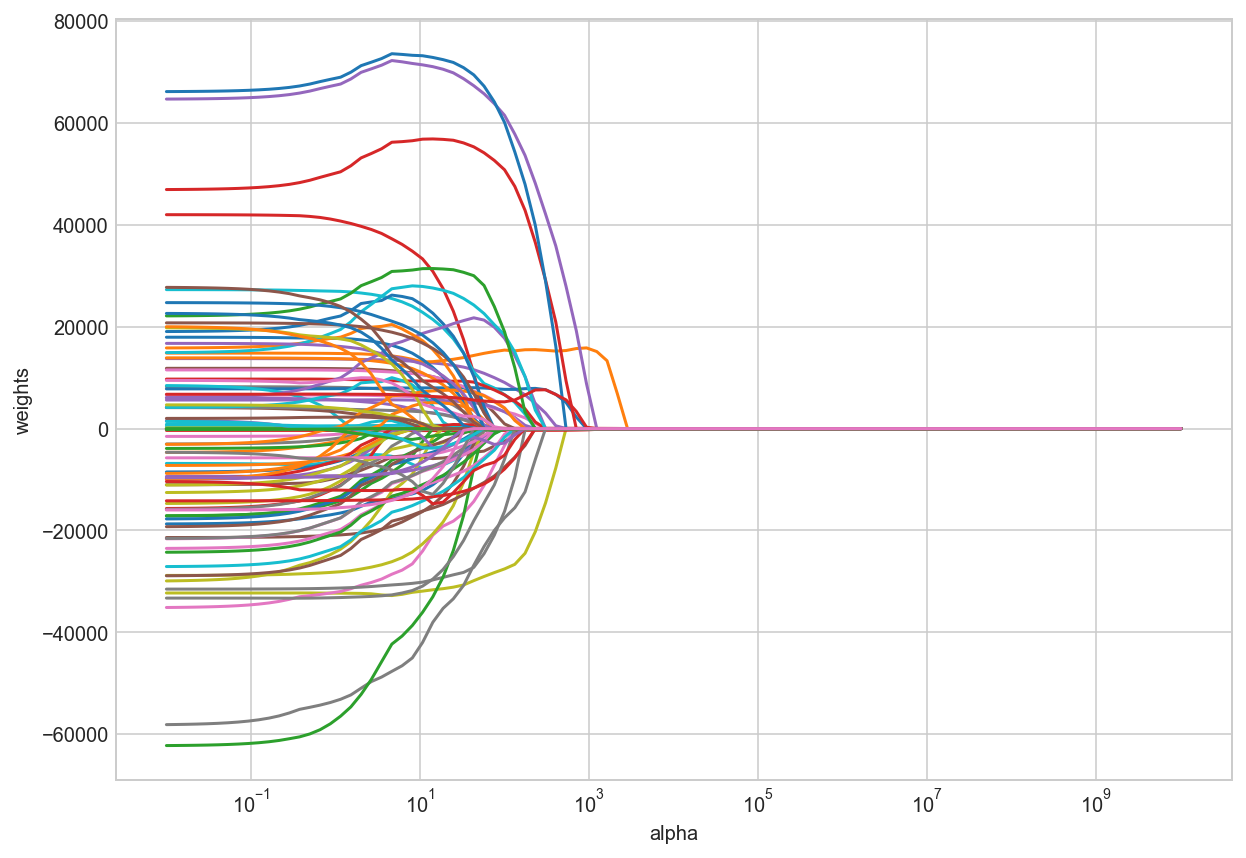

In [48]:
#Do Feature Selection using Lasso
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
lasso = Lasso(max_iter = 100000, normalize = True, fit_intercept=True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_Train, y_Train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10,7))
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [49]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True, fit_intercept=True)
lassocv.fit(X_Train, y_Train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_Train, y_Train)
mean_squared_error(y_Train, lasso.predict(X_Train))

1092347704.8645198

In [50]:
lasso.score(X_Train, y_Train), lasso.score(X_Test, y_Test)

(0.8252567109407629, 0.8412247061833446)

In [83]:
# Some of the coefficients are now reduced to exactly zero.
model1_coefs_df = pd.DataFrame(data=lasso.coef_, index=cols, columns=['M1Coeffs'])

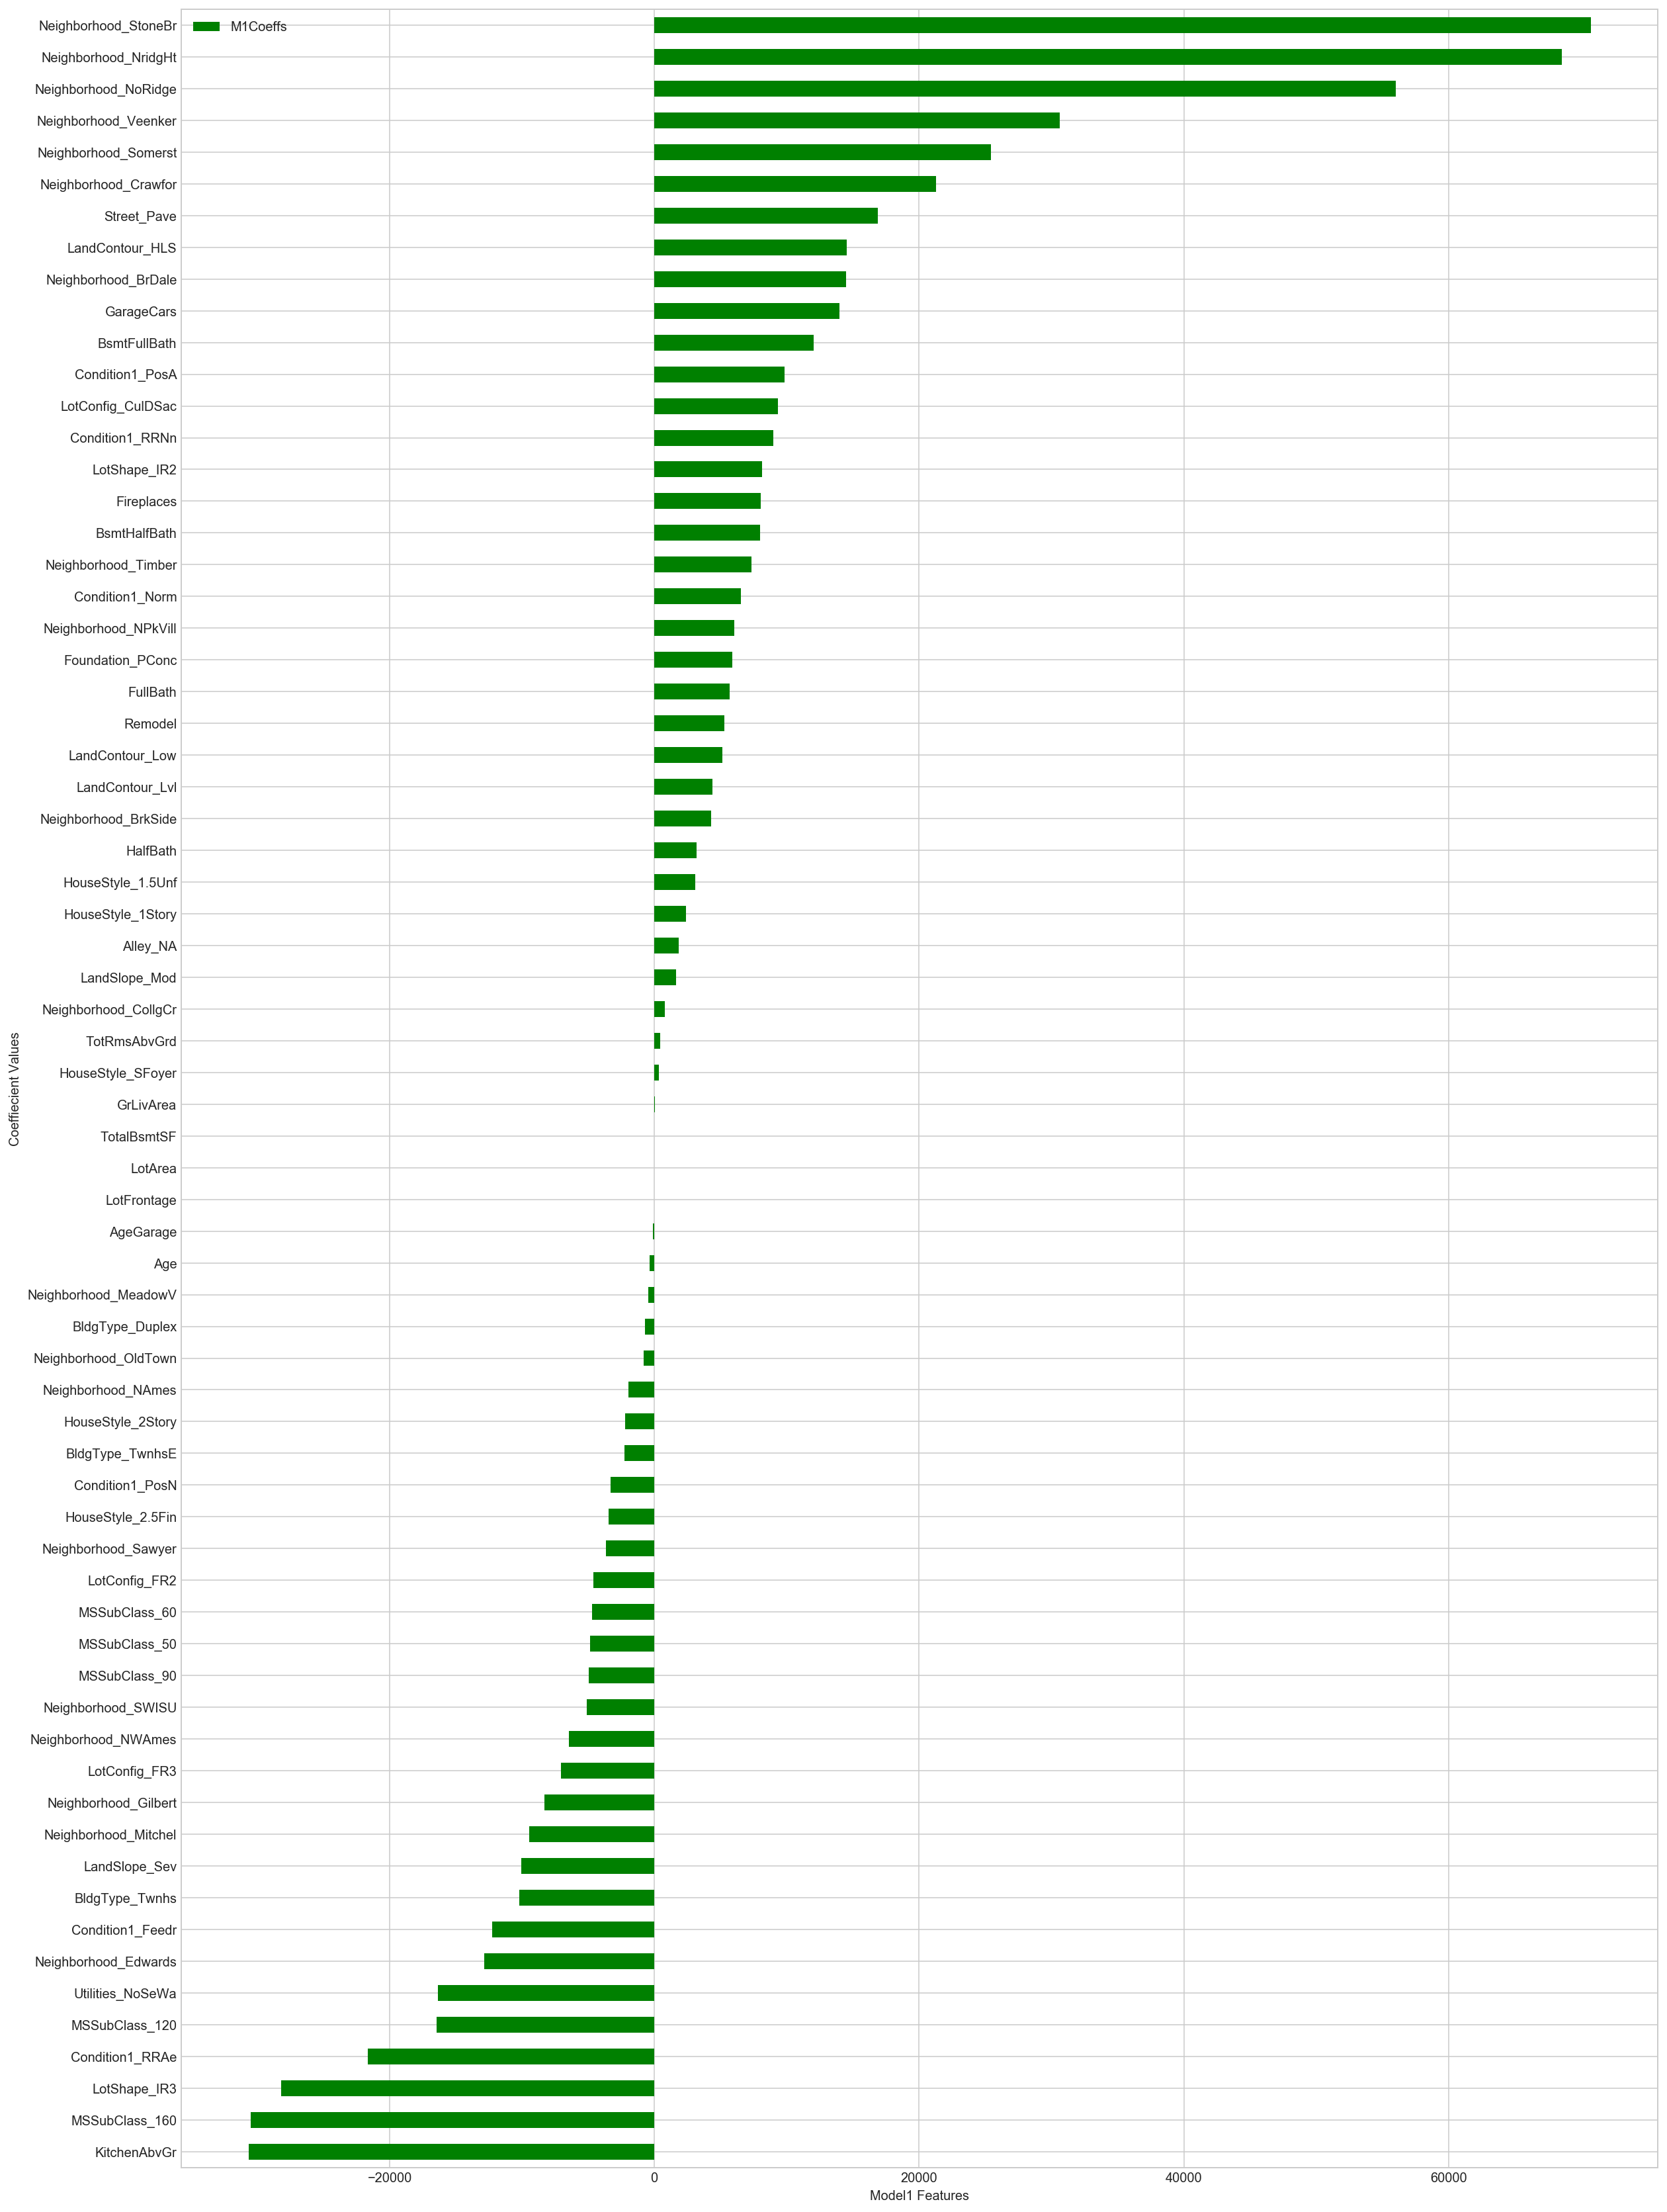

In [52]:
# Plot the coefficients to see which features contribute positively and negatively
model1_coefs_df = model1_coefs_df.sort_values(by='M1Coeffs', ascending=True)
model1_coefs_df[model1_coefs_df['M1Coeffs'] != 0].plot(kind='barh', figsize=(20,30), color='g')

ax = plt.gca()
ax.set_xlabel('Model1 Features')
ax.set_ylabel('Coeffiecient Values')
ax.legend()

# III. Interpretation

- In terms of models, Lasso has better prediction compared to using OLS with pvalue elimination
- Neighbourhood has the highest impact in pushing the price up in terms of fixed features
- Irregular Lot shapes, 2-STORY PUD - 1946 & NEWER and Kitchens above ground have the highest impact in pushing 
  the price down. Irregular lot shapes are not so easy to renovate in terms of design and appeal will be less. For
  kitchens above the ground, I think it makes sense that people will prefer the space above ground to be used more for
  rooms as it will give them more privacy

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

# I. MODEL 1.3 - Feature Elimination using Lasso

In [53]:
#Set-up Predictor and Target Matrices
cols = list(df_house_m2.columns.values)
cols.remove('SalePrice')
cols.remove('SaleCondition')
cols.remove('YrSold')

In [54]:
# Split the Train and Test data by Year Sold
X_Train = df_house_m2[df_house_m2['YrSold'] != 2010][cols]
y_Train = df_house_m2[df_house_m2['YrSold'] != 2010]['SalePrice'].values

X_Test = df_house_m2[df_house_m2['YrSold'] == 2010][cols]
y_Test = df_house_m2[df_house_m2['YrSold'] == 2010]['SalePrice'].values

In [55]:
# Generate alphas
alphas = 10**np.linspace(10,-2,100)*0.5

Text(0,0.5,'weights')

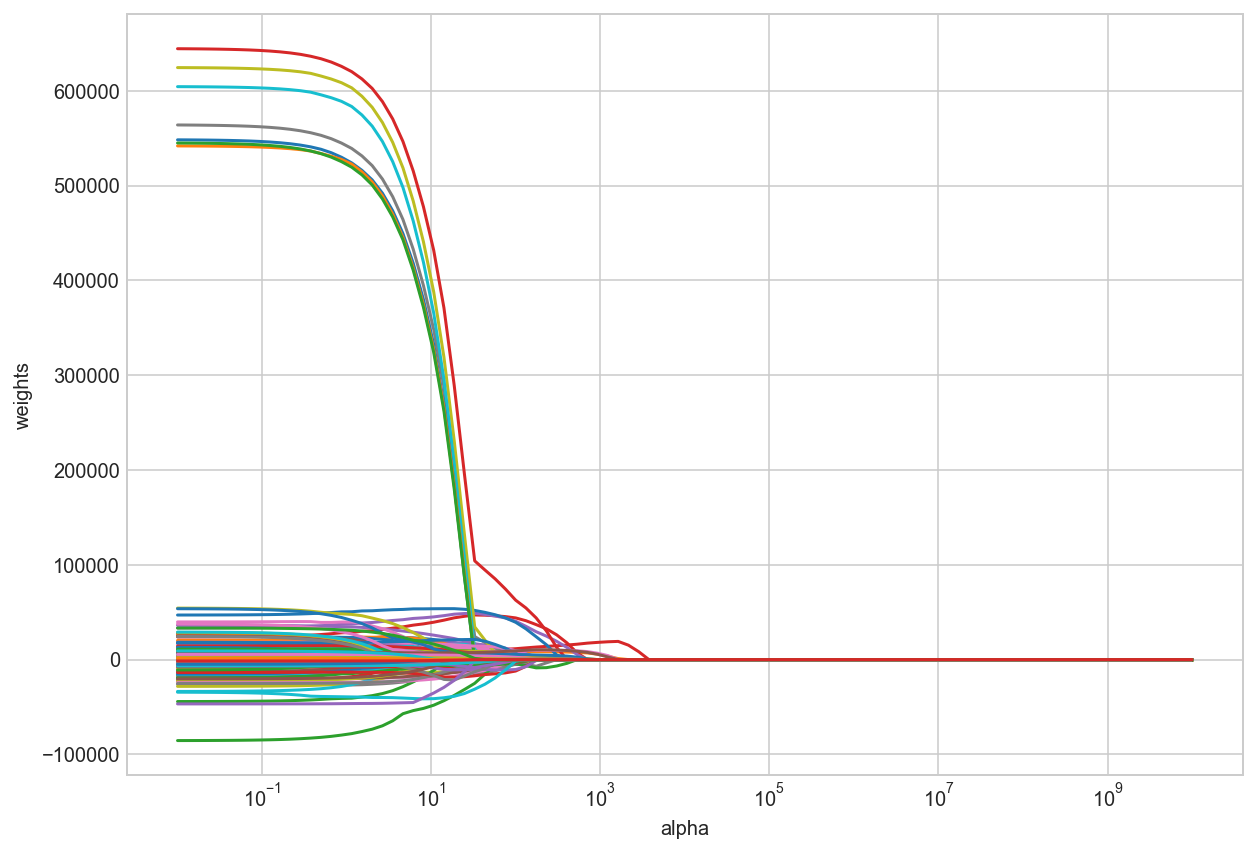

In [56]:
#Do Feature Selection using Lasso
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
lasso = Lasso(max_iter = 100000, normalize = True, fit_intercept=True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_Train, y_Train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10,7))
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [57]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True, fit_intercept=True)
lassocv.fit(X_Train, y_Train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_Train, y_Train)
mean_squared_error(y_Train, lasso.predict(X_Train))

790759851.477042

In [58]:
lasso.score(X_Train, y_Train), lasso.score(X_Test, y_Test)

(0.8735018376587058, 0.868883176779804)

In [84]:
# Some of the coefficients are now reduced to exactly zero.
model2_coefs_df = pd.DataFrame(data=lasso.coef_, index=cols, columns=['M2Coeffs'])

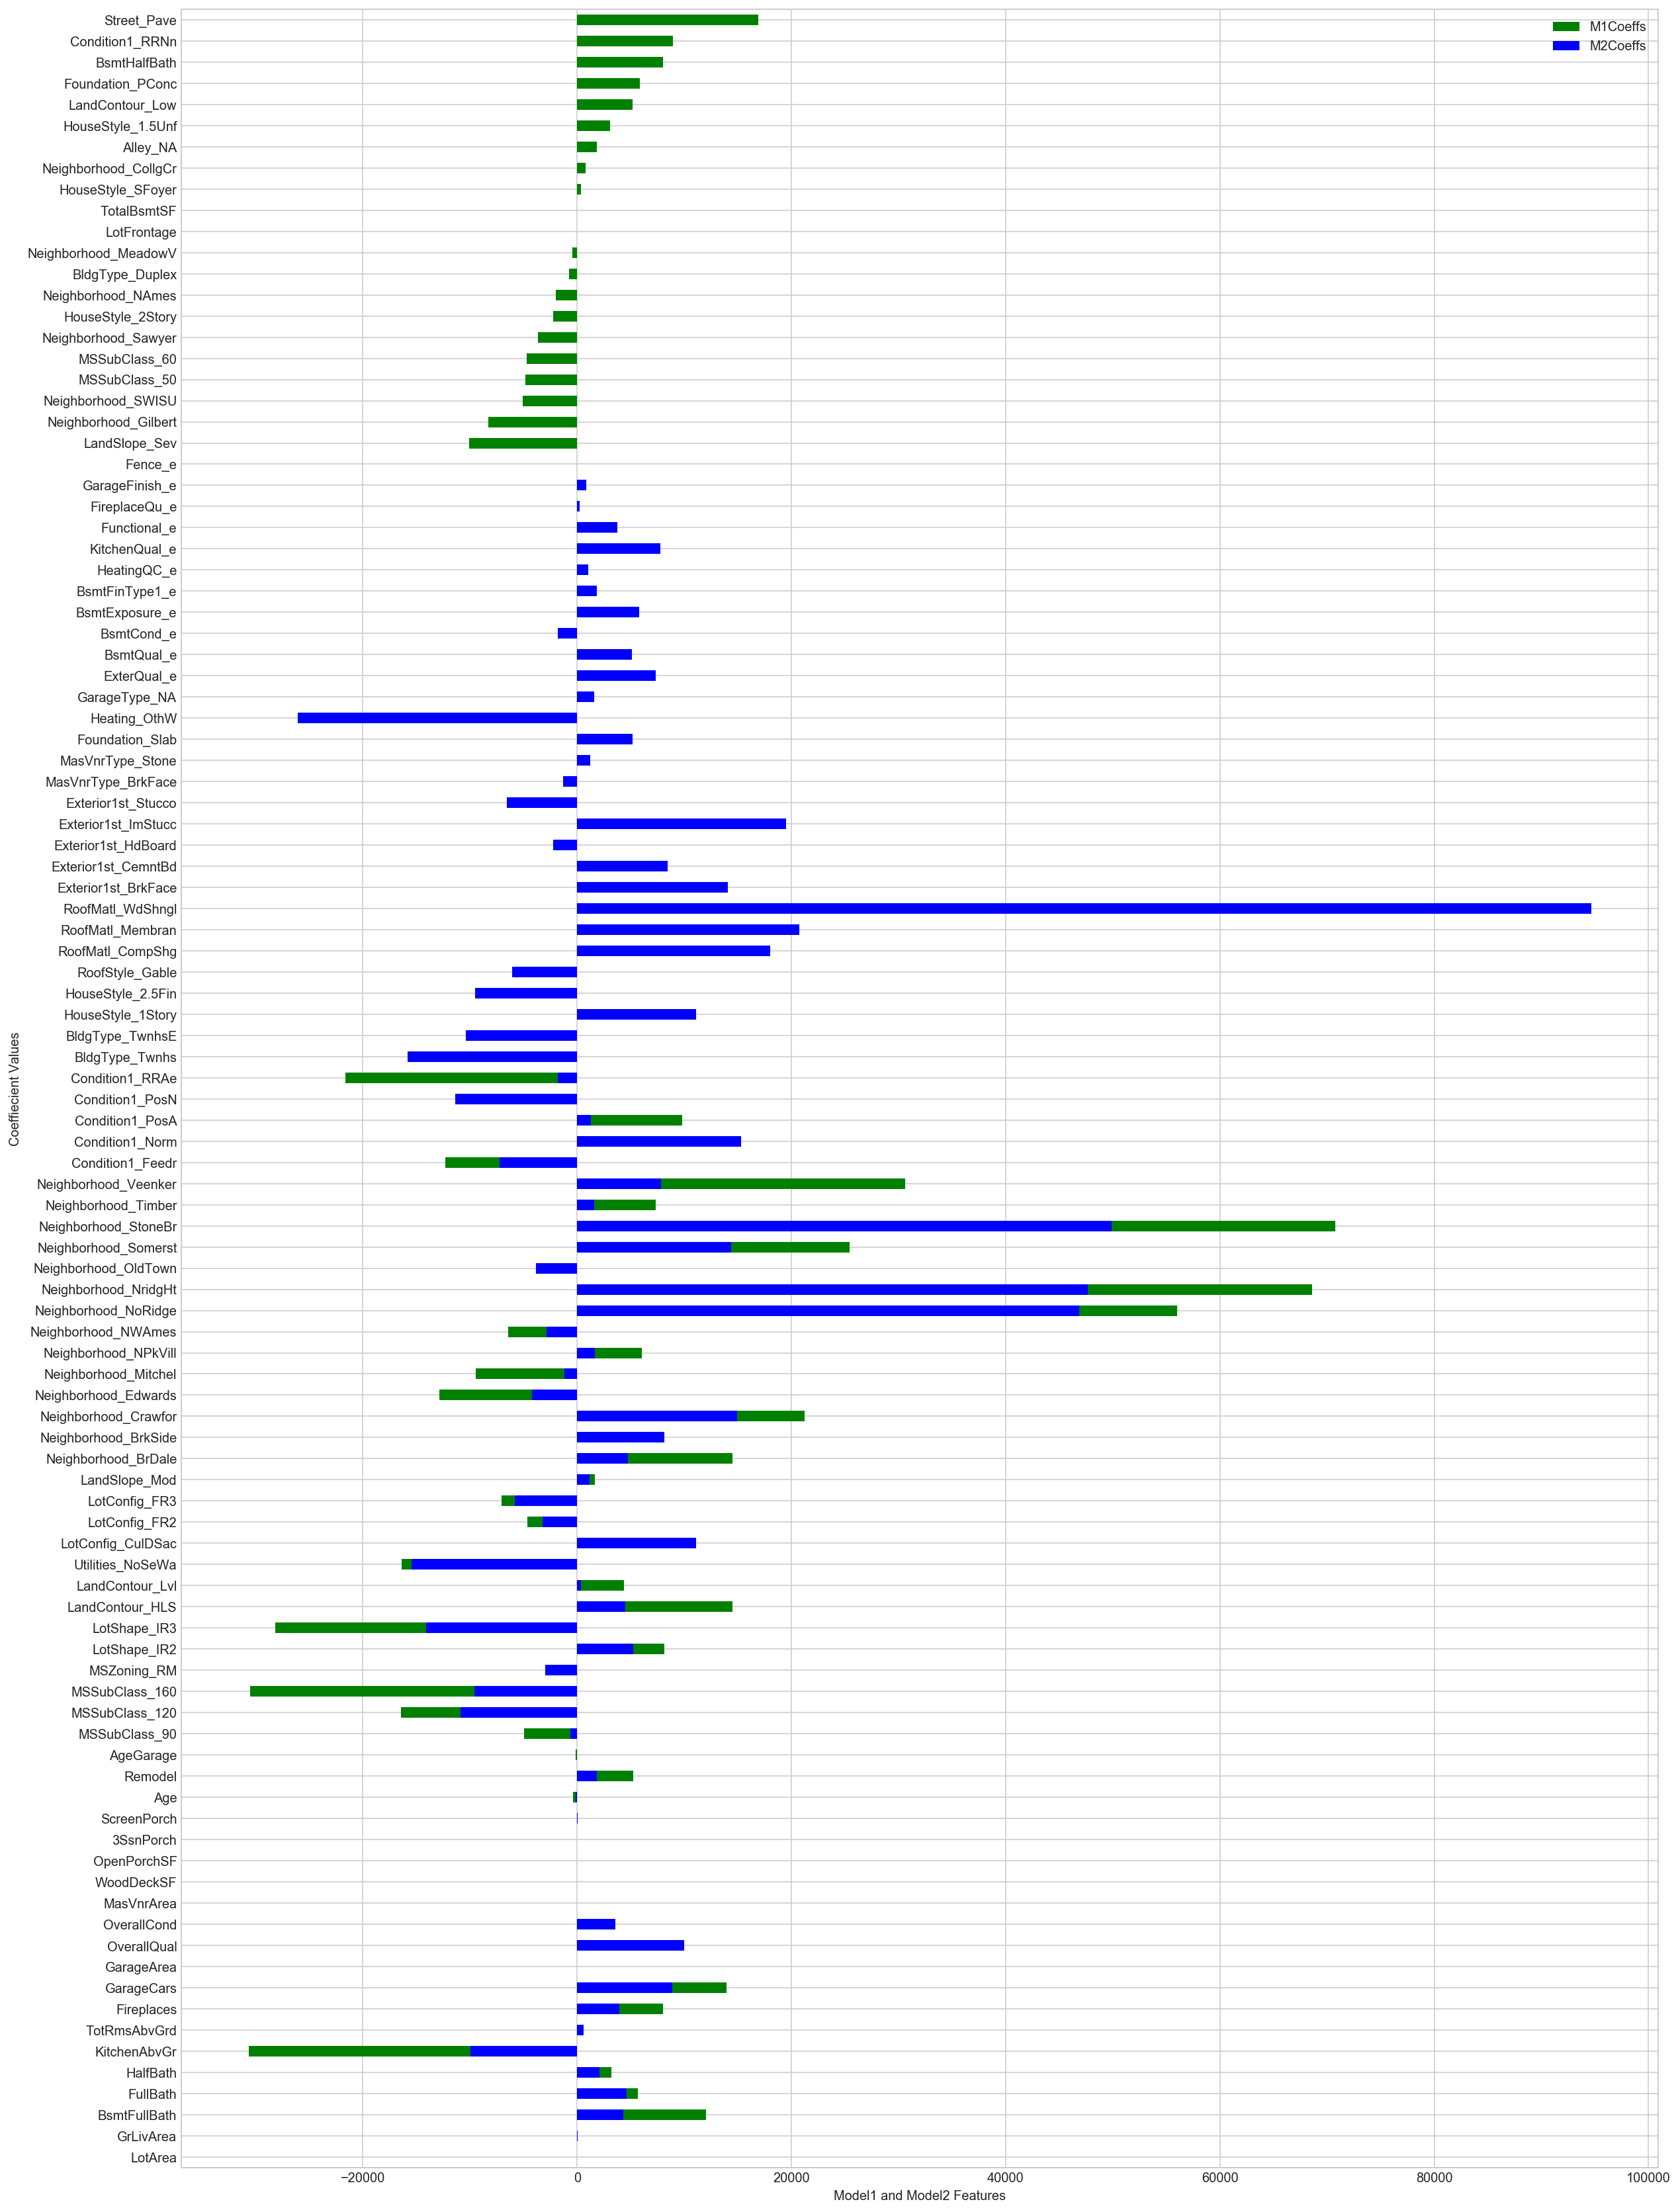

In [60]:
# Combine both Lasso Features from Model 1 and 2 and remove the 0 values
model1_coefs_df = model1_coefs_df[model1_coefs_df['M1Coeffs'] != 0]
model2_coefs_df = model2_coefs_df[model2_coefs_df['M2Coeffs'] != 0]
modelc_coefs_df = pd.concat([model2_coefs_df, model1_coefs_df], axis=1, sort=False)

# Plot the coefficients to see which features contribute positively and negatively
modelc_coefs_df['M1Coeffs'].plot(kind='barh', figsize=(20,30), color='g')
modelc_coefs_df['M2Coeffs'].plot(kind='barh', figsize=(20,30), color='b')

ax = plt.gca()
ax.set_xlabel('Model1 and Model2 Features')
ax.set_ylabel('Coeffiecient Values')
ax.legend()

In [61]:
from sklearn.model_selection import cross_val_score
scores_lsr = cross_val_score(lasso, X_Train, y_Train, cv=10,scoring='explained_variance')

In [62]:
print('Scores for k=10 fold validation:',scores_lsr)
print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_lsr.mean(), scores_lsr.std() * 2))

Scores for k=10 fold validation: [0.90219653 0.90651098 0.87179086 0.76735589 0.86419017 0.86367958
 0.86119906 0.82325847 0.62838506 0.89200395]
Est. explained variance: 0.84 (+/- 0.16)


# II. MODEL 1.4 - Model for Variance

In [63]:
# Create a Model to predict the variance
y_Train_Var = y_Train - lasso.predict(X_Train)
y_Test_Var = y_Test - lasso.predict(X_Test)

Text(0,0.5,'weights')

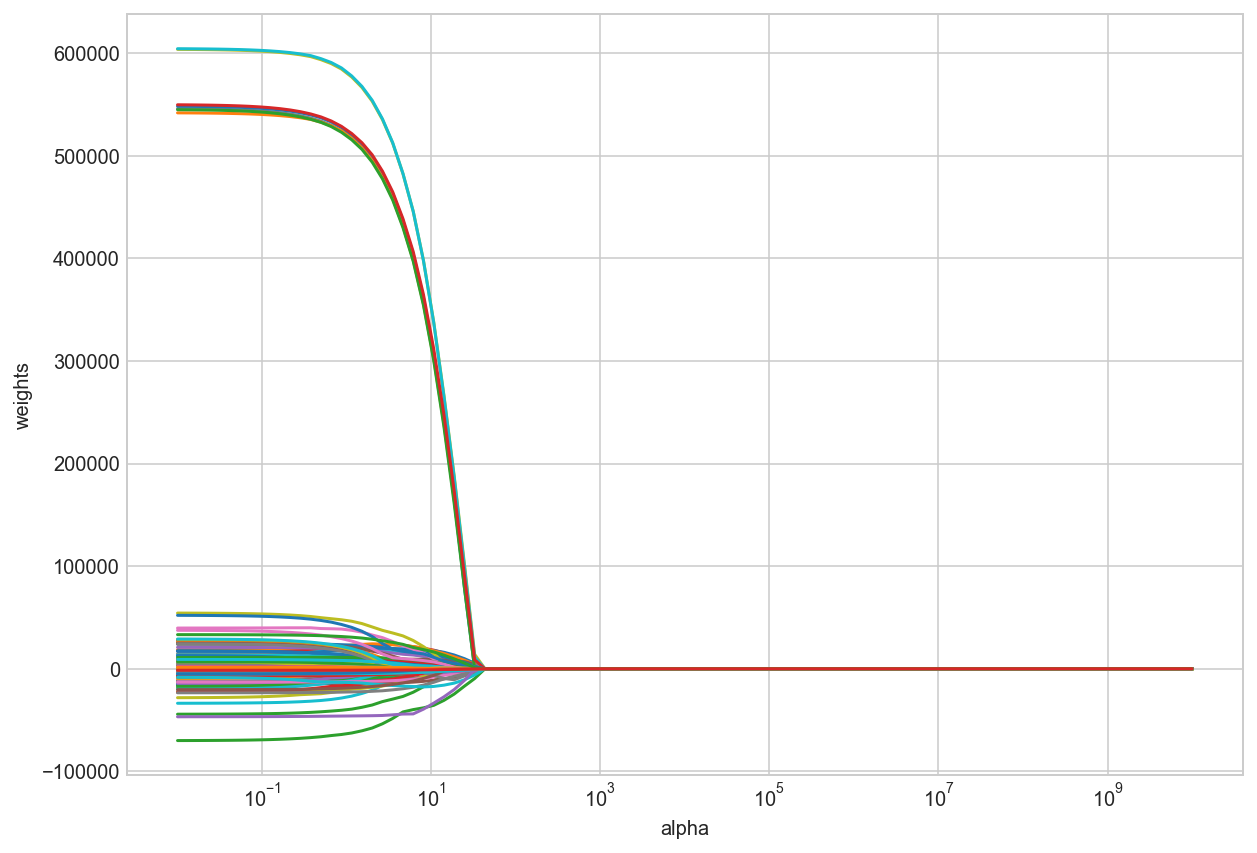

In [64]:
lasso = Lasso(max_iter = 100000, normalize = True, fit_intercept=True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_Train, y_Train_Var)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10,7))
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [65]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True, fit_intercept=True)
lassocv.fit(X_Train, y_Train_Var)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_Train, y_Train_Var)
mean_squared_error(y_Train_Var, lasso.predict(X_Train))

790759851.477042

In [66]:
lasso.score(X_Train, y_Train_Var), lasso.score(X_Test, y_Test_Var)

(0.0, -0.0006204388048562937)

In [67]:
# Some of the coefficients are now reduced to exactly zero.
model22_coefs_df = pd.DataFrame(data=lasso.coef_, index=cols, columns=['M22Coeffs'])
model22_coefs_df[model22_coefs_df['M22Coeffs']!=0]

M22Coeffs
GarageCars  2.717912e-13

# III. Interpretation

- By using Lasso and including the non-fixed features, the new model is able to achieve better scores than the first
  one
- Features that were highly emphasized by the previous model were either eliminated or reduced by the new
  model (Neighbourhood, MSSubclass)
- The new model suggests that quality of the house pushes the price up (especially the exterior features)
- https://shakeguys.com/2013/08/pros-and-cons-of-cedar-roofing/
- The link above shows that wood shingles roofing are expensive but they are effective for different weathers and can
  last longer
- Unconventional forms of heating has the greatest impact of pushing the price down (I think heating is an important
  consideration for the home buyers)
- The model did not take into account the seasonality of the sales (year and month)
- Previous EDA did show that some months have higher price especially January and mid year

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

# I. Create Model for SaleCondition = Abnorml using Undersampling + RF / XGBoost

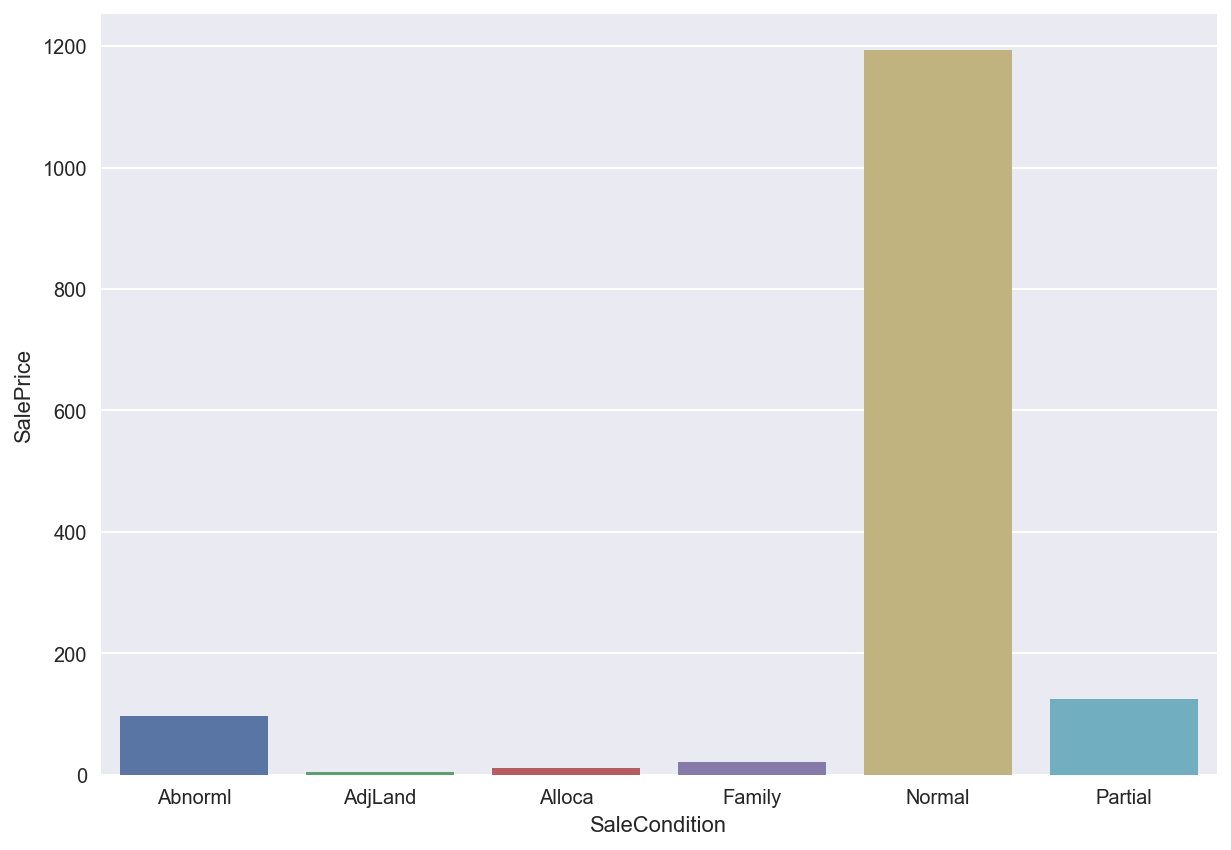

In [68]:
# Check the distribution of Housing Data based on Sale Condition
sns.set(rc={'figure.figsize':(10,7)})
sns.barplot(data=df_house_res.groupby('SaleCondition').count()[['SalePrice']],
            y='SalePrice', x=df_house_res.groupby('SaleCondition').count()[['SalePrice']].index.T)

In [69]:
# Create a copy of the 2nd dataframe to be used for 3rd model
df_house_m3 = df_house_m2.copy()

In [70]:
# Convert SaleCondition into dummy variables
df_house_m3 = pd.get_dummies(df_house_m3, columns=['SaleCondition'], drop_first=False)
df_house_m3[[column for column in df_house_m3.columns.tolist() if 'SaleCondition' in column]].sample(5)

SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
782                      0                      0                     0   
430                      1                      0                     0   
527                      0                      0                     0   
366                      0                      0                     0   
44                       0                      0                     0   

     SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
782                     0                     1                      0  
430                     0                     0                      0  
527                     0                     0                      1  
366                     0                     1                      0  
44                      0                     1                      0

In [71]:
# Set-up Predictor and Target Matrices
cols = list(df_house_m3.columns.values)
cols.remove('SalePrice')
cols.remove('SaleCondition_Abnorml')
cols.remove('SaleCondition_AdjLand')
cols.remove('SaleCondition_Alloca')
cols.remove('SaleCondition_Family')
cols.remove('SaleCondition_Normal')
cols.remove('SaleCondition_Partial')
cols.remove('YrSold')

X = df_house_m3[cols]
y = df_house_m3['SaleCondition_Abnorml'].values

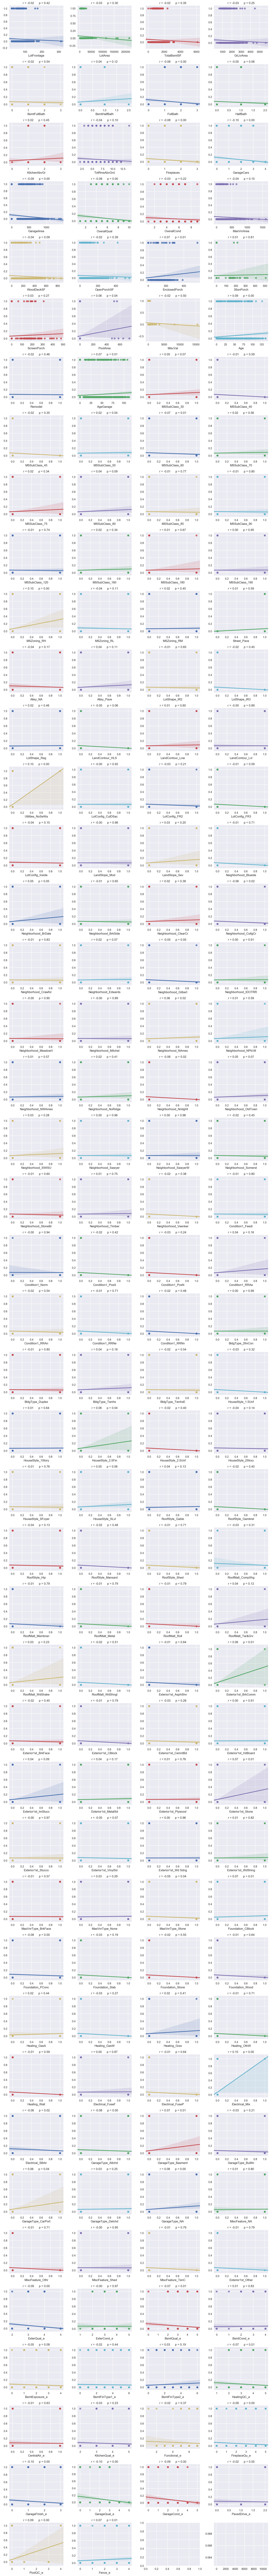

In [72]:
# Plot the correlations and p of numerical values vs Sale Condition Abnormal
nr_rows = 44
nr_cols = 4

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_plot_num_feats = X.columns.T

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(X[li_plot_num_feats[i]], y, ax = axs[r][c])
            stp = stats.pearsonr(X[li_plot_num_feats[i]], y)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

Observations for distribution SaleCondition = Abnorml in correlation with other features:
- LotArea <= 50000
- BsmtFullBath <= 2
- BsmtHalfBath <= 1
- HalfBath <= 1
- Fireplaces <= 2
- GarageCars <= 3
- GarageArea <= 1000
- OverallQual >= 2
- MasVnrArea <= 1000
- WoodDeckSF <= 600
- 3SsnPorch <= 300
- MiscVal <= 5000
- MSSubClass_40 == 0
- MSSubClass_45 == 0
- Street_Pave == 1
- LotShape_IR3 == 0
- LandContour_HLS == 0
- LotConfig_FR3 == 0
- Neighborhood_Blueste == 0
- Neighborhood_NridgHt == 0
- Neighborhood_Veenker == 0
- Condition1_PosA == 0
- Condition1_PosN == 0
- Condition1_RRNe == 0
- Condition1_RRNn == 0
- HouseStyle_1.5Unf == 0
- HouseStyle_2.5Unf == 0
- RoofStyle_Gambrel == 0
- RoofStyle_Mansard == 0
- RoofStyle_Shed == 0
- RoofStyle_Membran == 0
- RoofStyle_Metal == 0
- RoofStyle_Roll == 0
- RoofMatl_WoodShngl == 0
- Exterior1st_AspShn == 0
- Exterior1st_CBlock == 0
- Foundation_Slab == 0
- Foundation_Stone == 0
- Foundation_Wood == 0
- Heating_GasW == 0
- Heating_OthW == 0
- Heating_Wall == 0
- Electrical_FuseP == 0
- MiscFeature_Othr == 0
- MiscFeature_TenC == 0
- Exterior1st_Other == 0
- ExterQual_e <= 4

In [73]:
# Apply the filters based on the observations noted previously in order to boost the ratio of abnormal sales
# by Undersampling
df_house_m3_fil = df_house_m3[df_house_m3['LotArea'] <= 50000]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['BsmtFullBath'] <= 2]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['BsmtHalfBath'] <= 1]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['HalfBath'] <= 1]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Fireplaces'] <= 2]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['GarageCars'] <= 3]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['GarageArea'] <= 1000]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['OverallQual'] >= 2]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['MasVnrArea'] <= 1000]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['WoodDeckSF'] <= 600]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['3SsnPorch'] <= 300]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['MiscVal'] <= 5000]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['MSSubClass_40'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['MSSubClass_45'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Street_Pave'] == 1]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['LotShape_IR3'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['LandContour_HLS'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['LotConfig_FR3'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Neighborhood_Blueste'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Neighborhood_NridgHt'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Neighborhood_Veenker'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Condition1_PosA'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Condition1_PosN'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Condition1_RRNe'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Condition1_RRNn'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['HouseStyle_1.5Unf'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['HouseStyle_2.5Unf'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['RoofStyle_Gambrel'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['RoofStyle_Mansard'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['RoofStyle_Shed'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['RoofMatl_Membran'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['RoofMatl_Metal'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['RoofMatl_Roll'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['RoofMatl_WdShngl'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Exterior1st_AsphShn'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Exterior1st_CBlock'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Foundation_Slab'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Foundation_Stone'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Foundation_Wood'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Heating_GasW'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Heating_OthW'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Heating_Wall'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Electrical_FuseP'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['MiscFeature_Othr'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['MiscFeature_TenC'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['Exterior1st_Other'] == 0]
df_house_m3_fil = df_house_m3_fil[df_house_m3_fil['ExterQual_e'] <= 4]
df_house_m3_fil.shape

(1115, 182)

In [74]:
# Update X and y
X = df_house_m3_fil[cols]
y = df_house_m3_fil['SaleCondition_Abnorml'].values

In [75]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [76]:
# Check the distribution of abnormal in train and test
len(X_Train), sum(y_Train), len(X_Test), sum(y_Test)

(892, 80, 223, 16)

In [77]:
# Change the X values into DataFrame format
X_Train = pd.DataFrame(data=X_Train, columns=cols)
X_Test = pd.DataFrame(data=X_Test, columns=cols)

In [78]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [79]:
clf = RandomForestClassifier()
clf.fit(X_Train, y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [80]:
model3_fi_df = pd.DataFrame(data=clf.feature_importances_, index=X_Train.columns.T, columns=['FI3'])

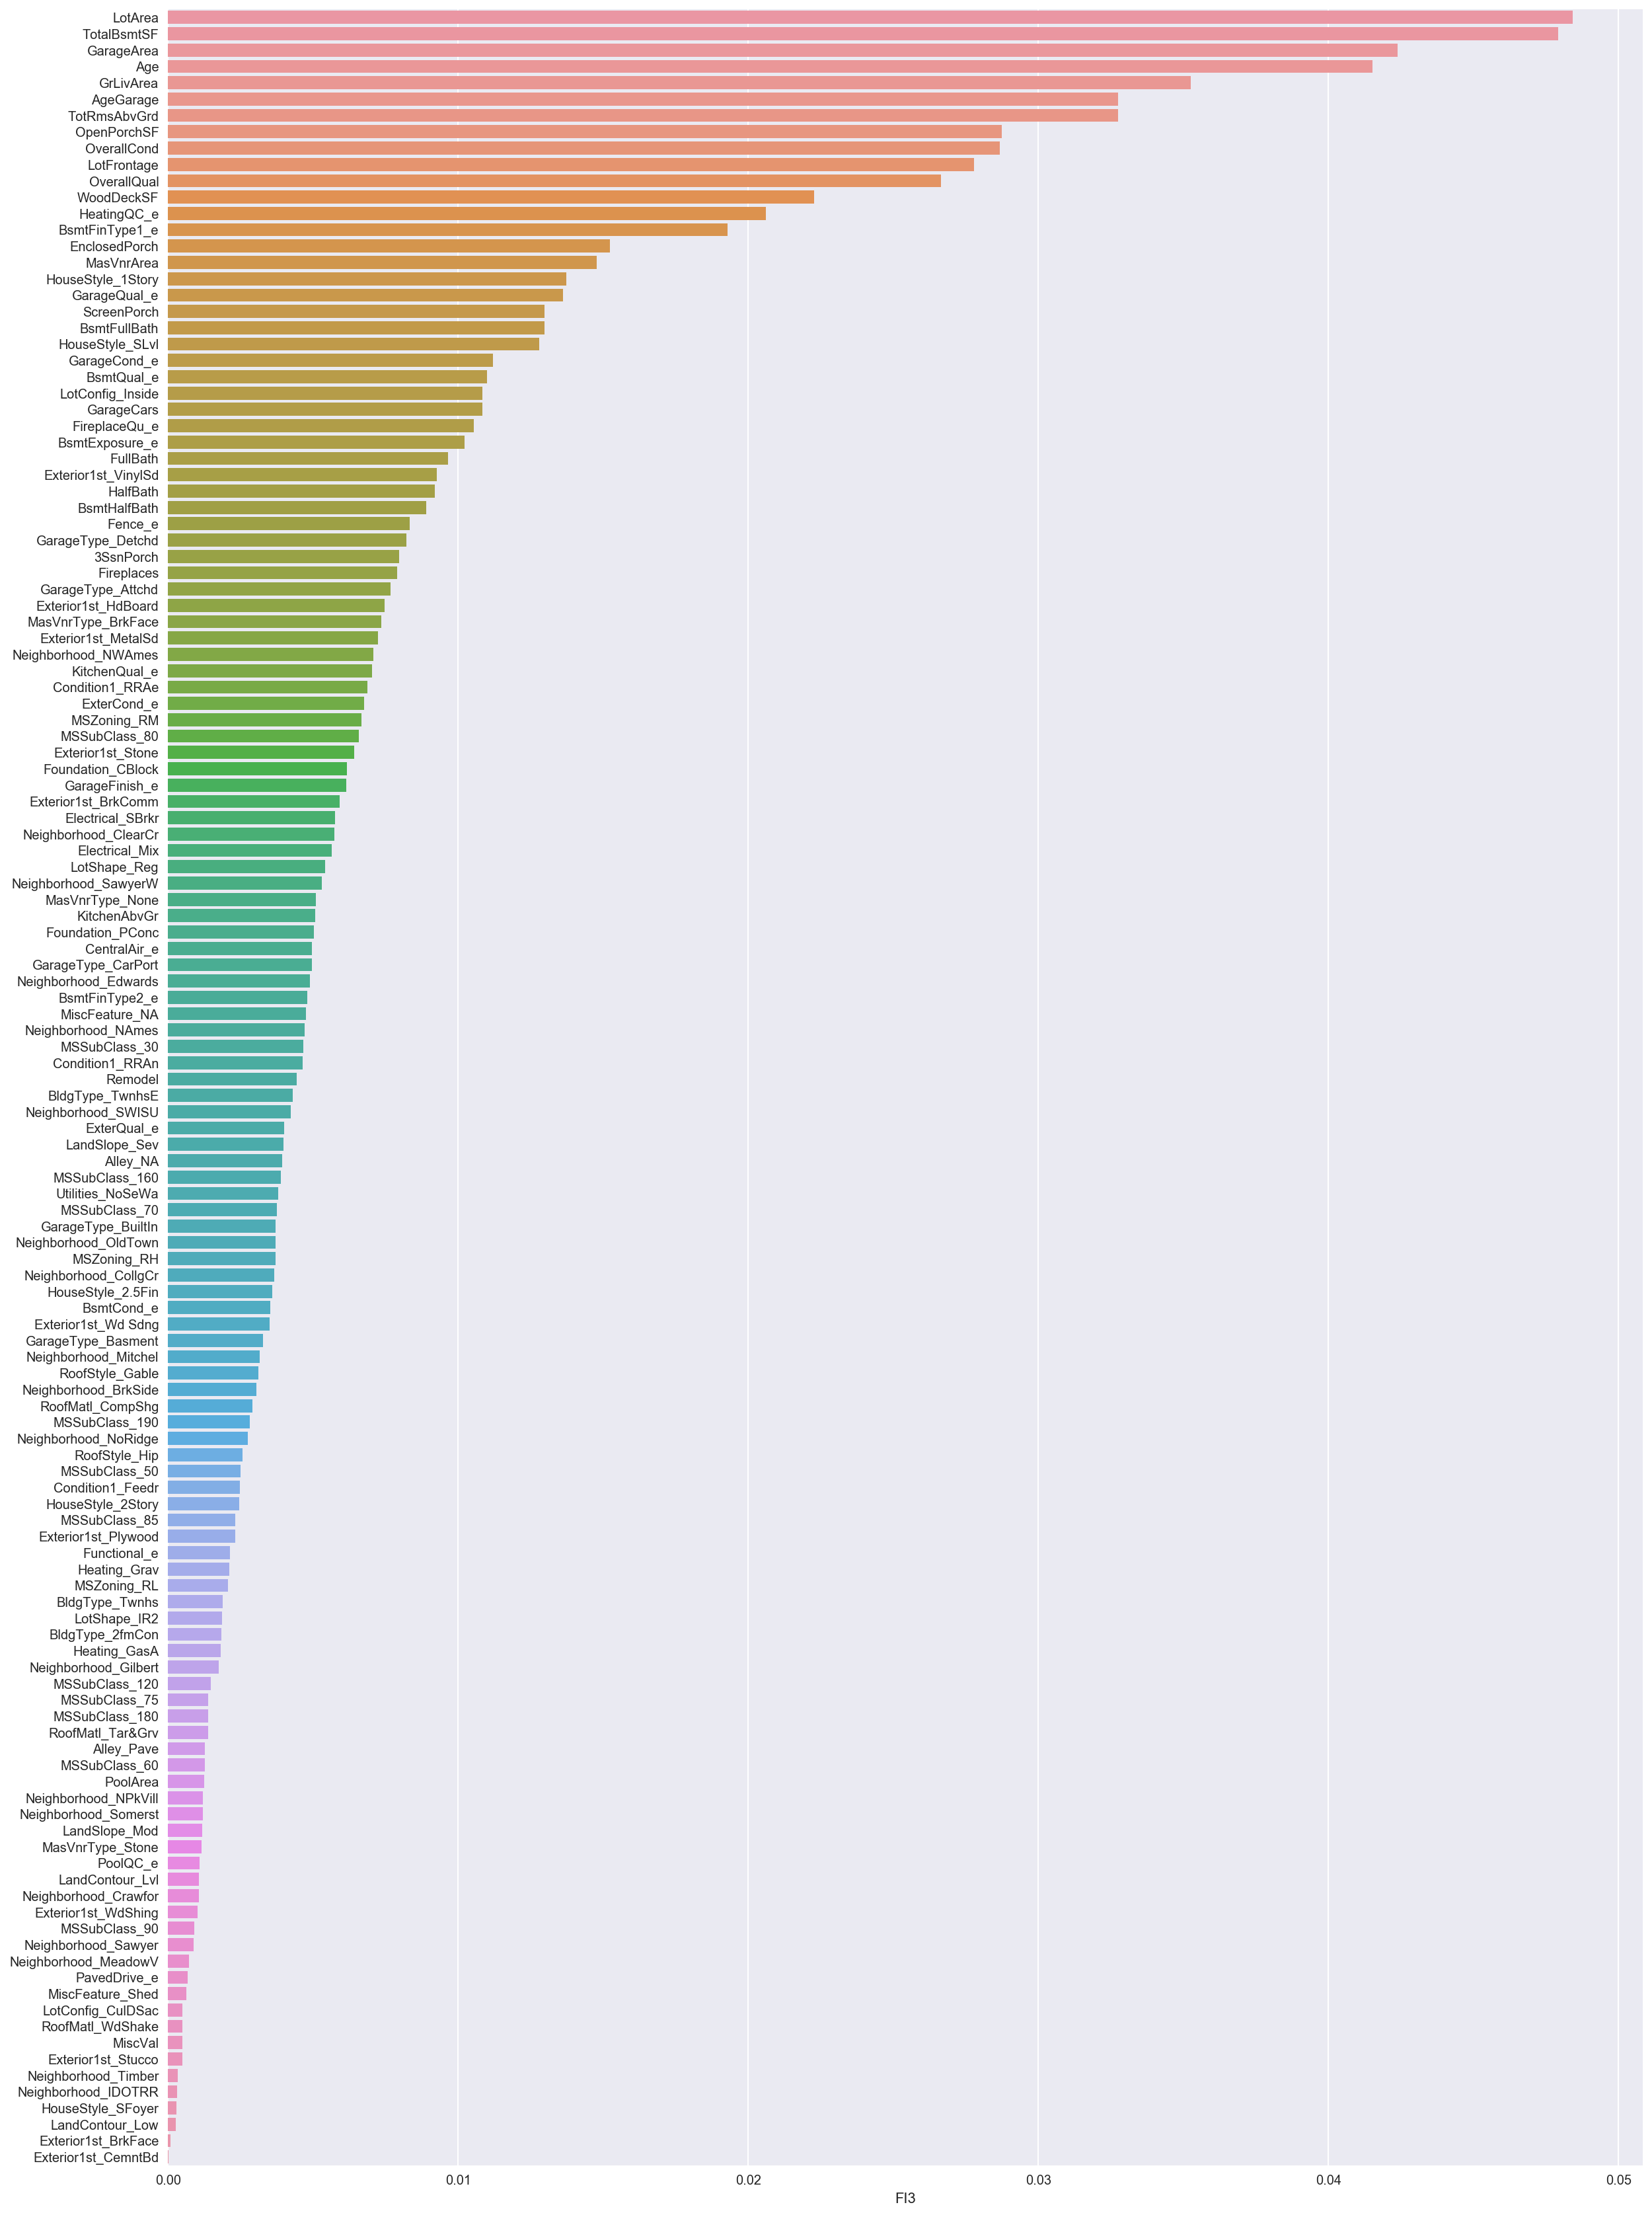

In [81]:
# Plot the Features sorted by decreasing importance
sns.set(rc={'figure.figsize':(20,30)})
sns.barplot(y=model3_fi_df[model3_fi_df['FI3'] > 0].sort_values(by='FI3', ascending=False).index, 
            x=model3_fi_df[model3_fi_df['FI3'] > 0].sort_values(by='FI3', ascending=False)['FI3'])

In [85]:
y_Pred = clf.predict(X_Test)
predictions = [round(value) for value in y_Pred]

print("Accuracy: %.2f%%" % (clf.score(X_Test, y_Pred) * 100.0))

Accuracy: 100.00%


In [86]:
metrics.classification_report(y_Test, predictions)

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'             precision    recall  f1-score   support\n\n          0       0.93      1.00      0.96       207\n          1       0.00      0.00      0.00        16\n\navg / total       0.86      0.93      0.89       223\n'

In [87]:
metrics.confusion_matrix(y_Test, y_Pred)

array([[207,   0],
       [ 16,   0]])

In [90]:
# Use XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.05).fit(X_Train, y_Train)

In [92]:
y_Pred = xgb_model.predict(X_Test)
predictions = [round(value) for value in y_Pred]

print("Accuracy: %.2f%%" % (xgb_model.score(X_Test, y_Pred) * 100.0))

Accuracy: 100.00%


/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [93]:
metrics.classification_report(y_Test, predictions)

'             precision    recall  f1-score   support\n\n          0       0.93      1.00      0.97       207\n          1       1.00      0.06      0.12        16\n\navg / total       0.94      0.93      0.90       223\n'

In [94]:
metrics.confusion_matrix(y_Test, predictions)

array([[207,   0],
       [ 15,   1]])

# II. Create Model for SaleCondition = Abnorml using Undersampling + SMOTE + RF

In [95]:
# Use SMOTE first and do Random Forest
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1.0)
X_Res, y_Res = sm.fit_sample(X, y)

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [96]:
X_Train_Res, X_Test_Res, y_Train_Res, y_Test_res = train_test_split(X_Res,y_Res,test_size = .2,random_state=12)

In [97]:
# Change the X values into DataFrame format
X_Train_Res = pd.DataFrame(data=X_Train_Res, columns=cols)
X_Test_Res = pd.DataFrame(data=X_Test_Res, columns=cols)

In [98]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(X_Train_Res, y_Train_Res)
print("Accuracy: %.2f%%" % (clf_rf.score(X_Test_Res, y_Test_res) * 100.0))

Accuracy: 93.63%


In [99]:
y_Pred_Res = clf_rf.predict(X_Test_Res)
predictions_Res = [round(value) for value in y_Pred_Res]

In [100]:
metrics.classification_report(y_Test_res, predictions_Res)

'             precision    recall  f1-score   support\n\n          0       0.91      0.97      0.94       210\n          1       0.97      0.90      0.93       198\n\navg / total       0.94      0.94      0.94       408\n'

In [101]:
metrics.confusion_matrix(y_Test_res, predictions_Res)

array([[204,   6],
       [ 20, 178]])

In [102]:
model4_fi_df = pd.DataFrame(data=clf_rf.feature_importances_, index=X_Train_Res.columns.T, columns=['FI4'])

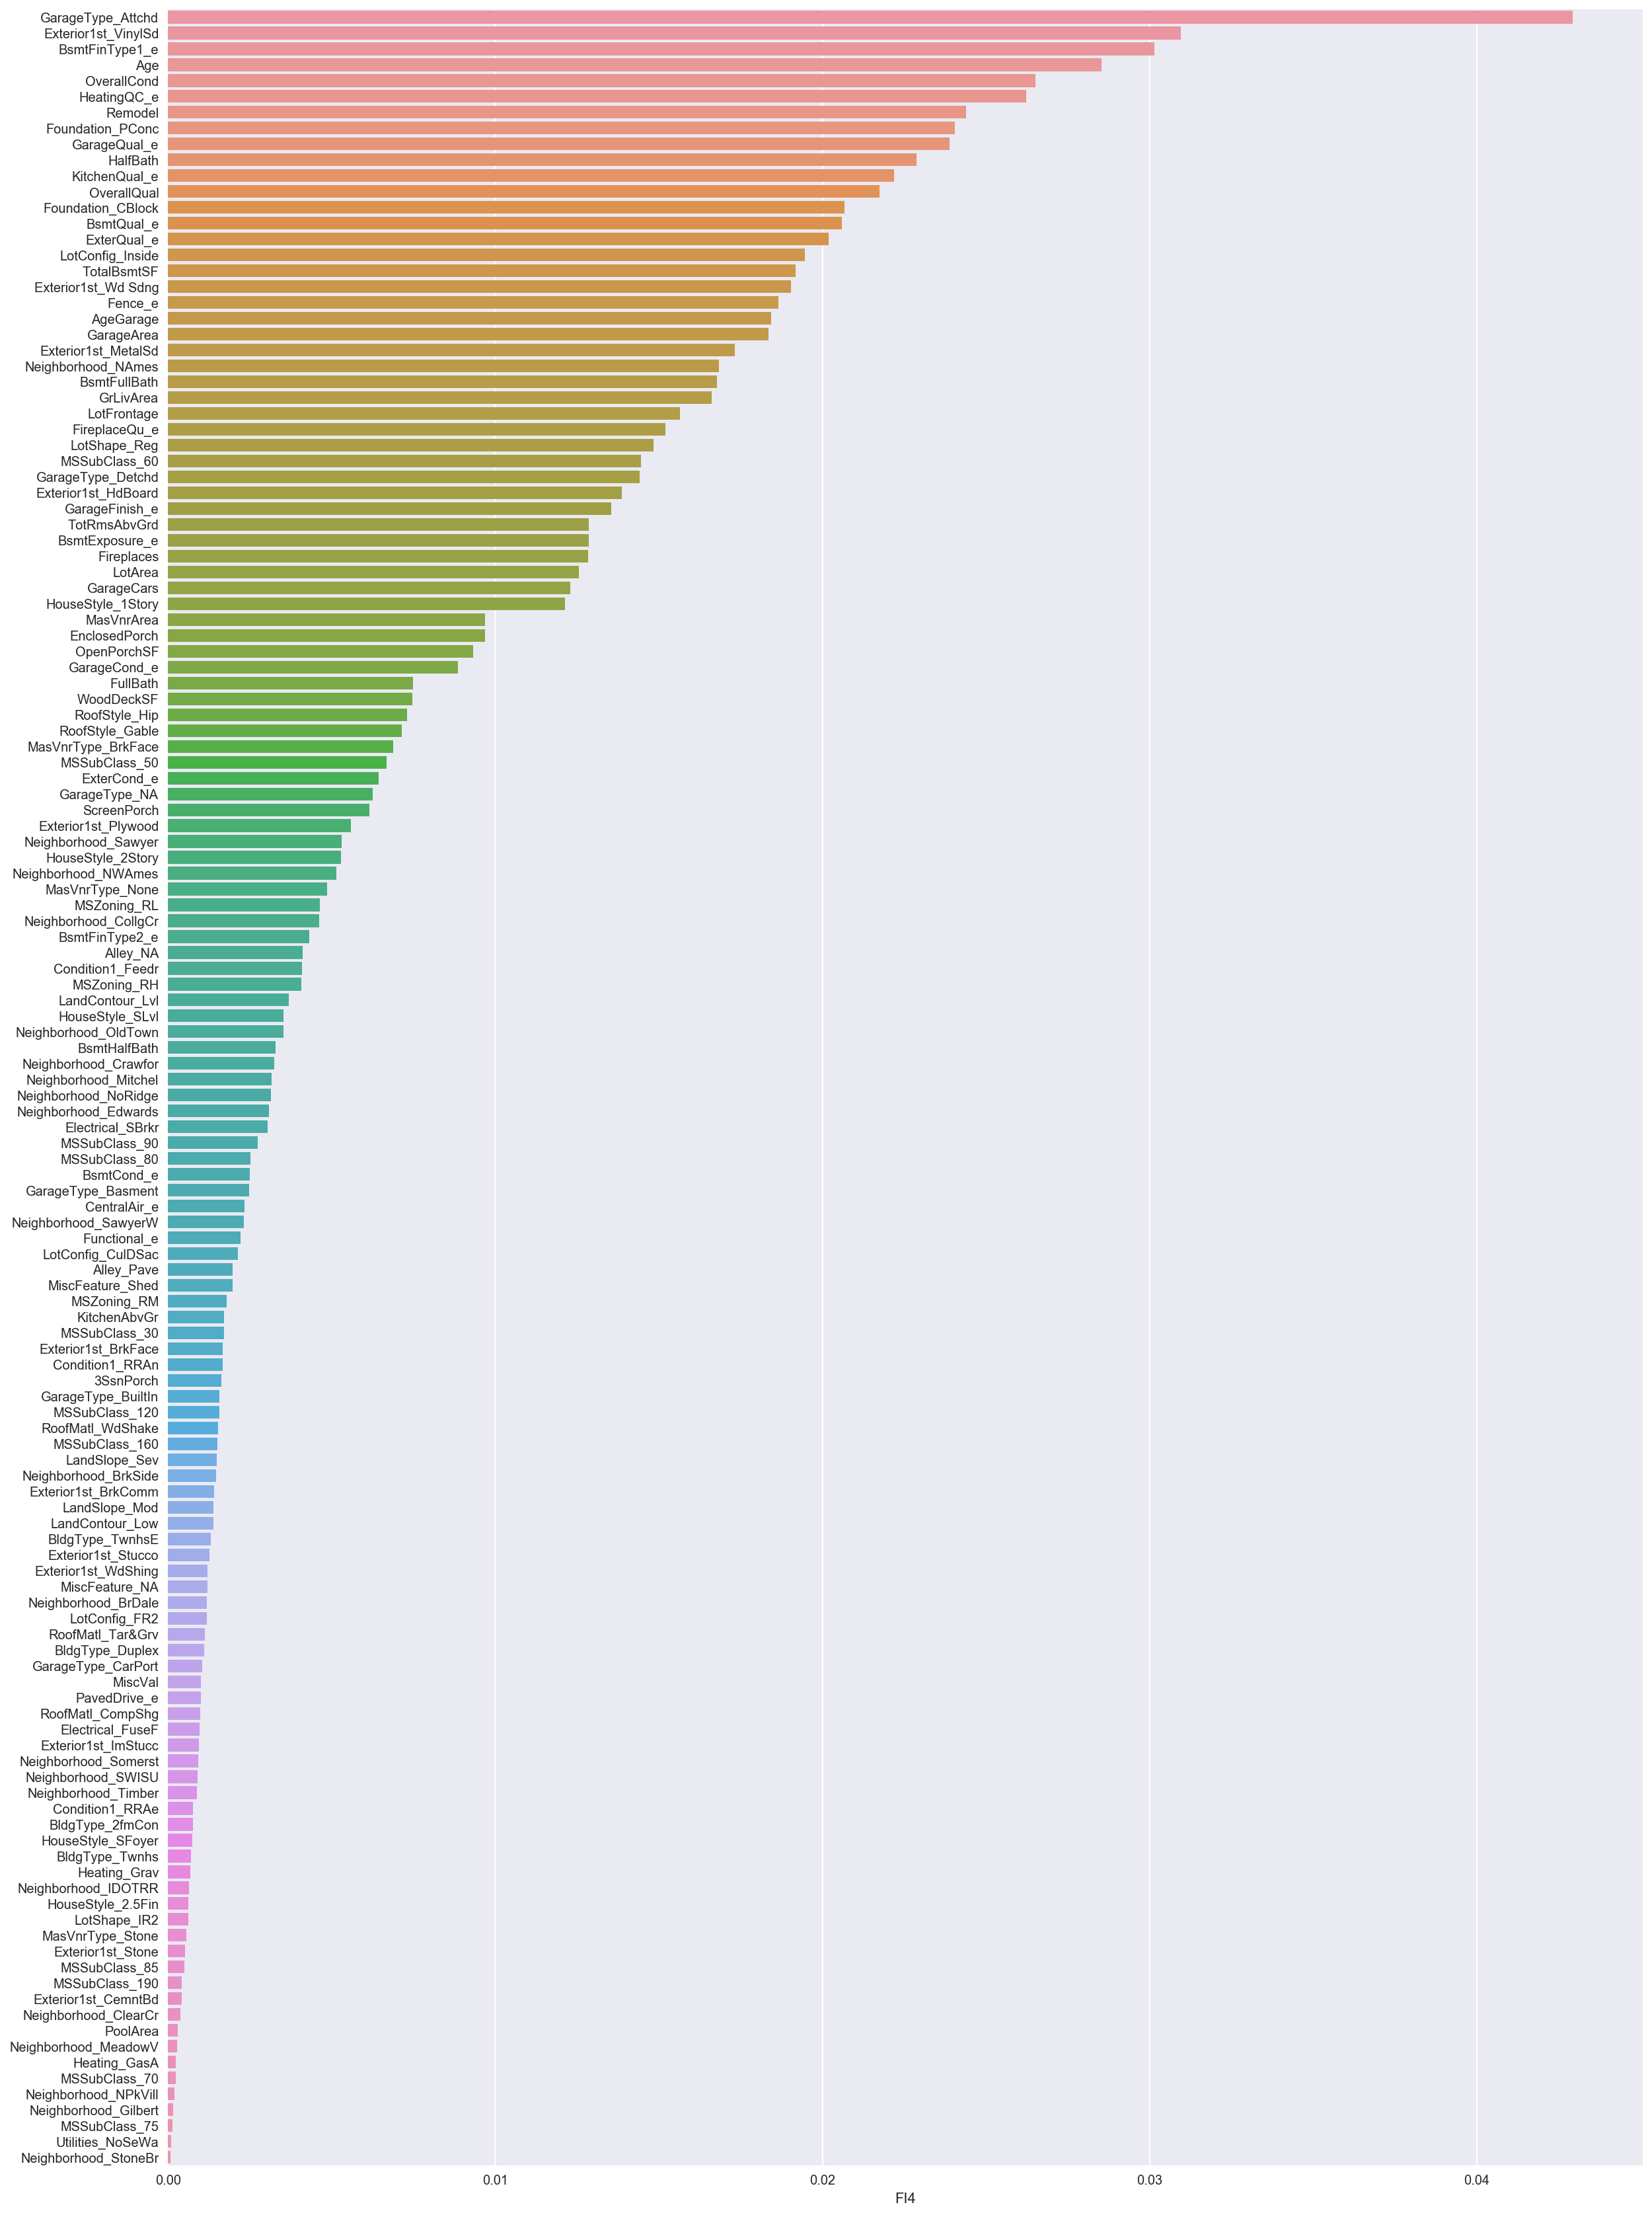

In [103]:
# Plot the Features sorted by decreasing importance
sns.set(rc={'figure.figsize':(20,30)})
sns.barplot(y=model4_fi_df[model4_fi_df['FI4'] > 0].sort_values(by='FI4', ascending=False).index, 
            x=model4_fi_df[model4_fi_df['FI4'] > 0].sort_values(by='FI4', ascending=False)['FI4'])

# II. Interpretation

- Features which are general premium indicators (Condition, Quality and Finishing) seems to be the best way to predict   whether the record is an abnormal sale
- The 1st Model is not useful as it is unable to predict any TN (see the results) except for XGBoost
- The 2nd Model is better at it is able to predict both TP and TN
- Since the data points for Abnormal Sale is only around 7% of the entire sample, the predictions of Model 2 is far    from conclusive as there is not sufficient data to predict new target data in the future